# Advanced-Lane-Lines
The goal of this project is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.


The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import glob
import pickle
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

## 1) Camera Calibration

In [ ]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

#Number of corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images_calib = glob.glob('./camera_cal/*.jpg')

for fname in images_calib:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (nx,ny), corners2,ret)
        #fig = plt.figure()
        #plt.imshow(img)
        #plt.title('Camera calibration')
        
# Perform the camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
        
# Create a dictionary with camera info        
calibration_info = { "ret": ret, "mtx": mtx, "dist": dist, "rvecs": rvecs,
"tvecs": tvecs }

# Save camera calibration info in a file
pickle.dump( calibration_info, open( "calib_info.p", "wb" ) )


## 2) Distortion correction

In [2]:
# Remove distortion from images
def undistort(img, mtx, dist, show=False):

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
        ax1.set_title('Original Image')
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image')
    
    return undist    

### Example distortion correction on images

In [3]:
# Load calibration info
cal_pickle = pickle.load( open("calib_info.p", "rb" ) )
mtx_l = cal_pickle["mtx"]
dist_l = cal_pickle["dist"]

### Test undistort on chessboard picture

In [ ]:
# Lead test image
img = cv2.imread('./camera_cal/calibration1.jpg')
# Undistor image
undistort(img,mtx_l, dist_l, show=True)

In [ ]:
images_list = glob.glob('./test_images/*.jpg')

for fname in images_list:
    img = cv2.imread(fname)
    undistort(img,mtx_l, dist_l, show=True)
    

# Define Mask to detect lines

In [4]:
# Masks the image based on gradient absolute value.
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output


# Masks the image based on gradient magnitude.
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

# Masks the image based on gradient direction.
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

def color_threshold_hls(image, s_thresh=(100,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    #plt.figure()
    #plt.imshow(s_binary)
    #plt.title('hls')
    
    return s_binary

def color_threshold_luv(image, l_thresh=(100,255)):
    l = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)[:,:,0]

    #plt.figure()
    #plt.imshow(l,cmap='gray')
    #plt.title('luv- l channel')
    s_binary = np.zeros_like(l)
    s_binary[(l >= l_thresh[0]) & (l <= l_thresh[1])] = 1
    #plt.figure()
    #plt.imshow(s_binary,cmap='gray')
    #plt.title('luv')
    
    return s_binary


def color_treshold_lab(image, b_thresh, l_thresh):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    l_channel = lab[:,:,0]
    #plt.figure()
    #plt.imshow(l_channel,cmap='gray')
    #plt.title('lab-l channel')
    #plt.figure()
    #plt.imshow(b_channel,cmap='gray')
    #plt.title('lab-b channel')
               
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <=  l_thresh[1])] = 1
    #plt.figure()
    #plt.imshow(l_binary,cmap='gray')
    #plt.title('lab-l threshold')
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <=  b_thresh[1])] = 1
    #plt.figure()
    #plt.imshow(b_binary,cmap='gray')
    #plt.title('lab-b threshold')    
    combined_binary = np.zeros_like(b_channel)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    #plt.figure()
    #plt.imshow(combined_binary,cmap='gray')
    #plt.title('lab - l and b combined')

    return combined_binary

def get_mask(image, ksize=3, show = False):
    

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    #image_blur = cv2.GaussianBlur(image, (3, 3), 0)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    #plt.figure()
    #plt.imshow(s_channel)
    #plt.title('s_channel')
    
    gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(s_channel, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    #plt.figure()
    #plt.imshow(gradx)
    #plt.title('gradx')
    mag_binary = mag_thresh(s_channel, sobel_kernel=ksize, mag_thresh=(20, 100))
    #plt.figure()
    #plt.imshow(mag_binary)
    #plt.title('mag_binary')
    dir_binary = dir_threshold(s_channel, sobel_kernel=ksize, thresh=(0.7, 1.3))
    #plt.figure()
    #plt.imshow(dir_binary)
    #plt.title('dir_binary')
    g_combined = np.zeros_like(dir_binary)
    g_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #g_combined[(gradx == 1)  | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #plt.figure()
    #plt.imshow(g_combined)
    #plt.title('gradient mask before')
    kernel = np.ones((5,5),np.uint8)
    g_combined = cv2.morphologyEx(g_combined, cv2.MORPH_OPEN, kernel)
    #plt.figure()
    #plt.imshow(g_combined,cmap='gray')
    #plt.title('gradient mask')
    
    
    #color_binary_hsl = color_threshold_hls(image, s_thresh=(200,255))
    color_binary_luv = color_threshold_luv(image, l_thresh=(210,255))
    color_binary_lab = color_treshold_lab(image, b_thresh=(155,255), l_thresh=(230,255))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(color_binary_luv == 1) | (color_binary_lab == 1)] = 1
    
    
        
    all_combined = np.zeros_like(image[:,:,0])
    #g_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    all_combined[(g_combined == 1)  | (combined_binary == 1) ] = 1

    
    return all_combined, combined_binary



# Test the masks

In [ ]:
images_list = glob.glob('./test_images/*.jpg')

for fname in images_list:
    image = mpimg.imread(fname)
    image = undistort(image, mtx_l, dist_l, show=False)
    result_g, result_c = get_mask(image, ksize=3 )

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('result_g', fontsize=18)
    ax2.axis('off')
    ax2.imshow(result_g)
    ax2.set_title('All', fontsize=18)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Original', fontsize=18)
    ax2.axis('off')
    ax2.imshow(result_c)
    ax2.set_title('Color segmentation', fontsize=18)




# Perspective Transform

In [5]:
def perspective_transform(gray, mtx_l, dist_l):

    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    (h, w) = (gray.shape[0], gray.shape[1])
    # Define source points and destination 
    src = np.float32([[  564. ,  450.],[716. ,  450.],[ -100. ,  720.],[ 1380. ,  720.]])
    dst = np.float32([[  100. , 0.],[1180. ,   0.],[100.  , 720.],[ 1180. ,  720.]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(gray, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv


## Test perspective transform

In [ ]:
images_list = glob.glob('./test_images/*.jpg')

for fname in images_list:
  
    image = mpimg.imread(fname)
    image = undistort(image, mtx_l, dist_l, show=False)
    
    result,M,Minv = perspective_transform(image, mtx_l, dist_l)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Original', fontsize=18)
    ax2.axis('off')
    ax2.imshow(result)
    ax2.set_title('Perspective Transform', fontsize=18)


## Line Finding Method: Peaks in a Histogram

In [6]:
def find_lanes(binary_warped, nwindows = 9):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    plt.figure()

    plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty 


def draw_lines(image, binary_warped, left_fitx, right_fitx, ploty, Minv ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

def compute_radius_offset(leftx, lefty, rightx, righty, shape):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]* shape[0]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]* shape[0]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Offset from center
    offset_px = 640 - (leftx[-1] + rightx[-1])/2
    offset_m = offset_px*xm_per_pix
    print(offset_m)
        
    return left_curverad, right_curverad, offset_m

## Pipeline test on images

-0.954071428571


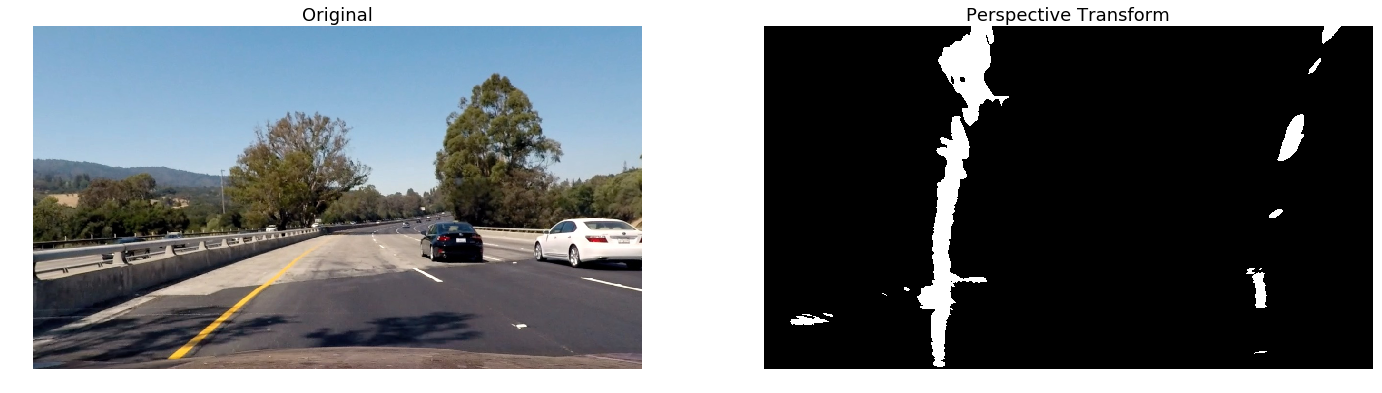

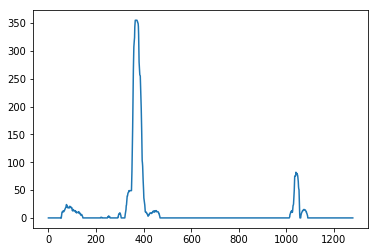

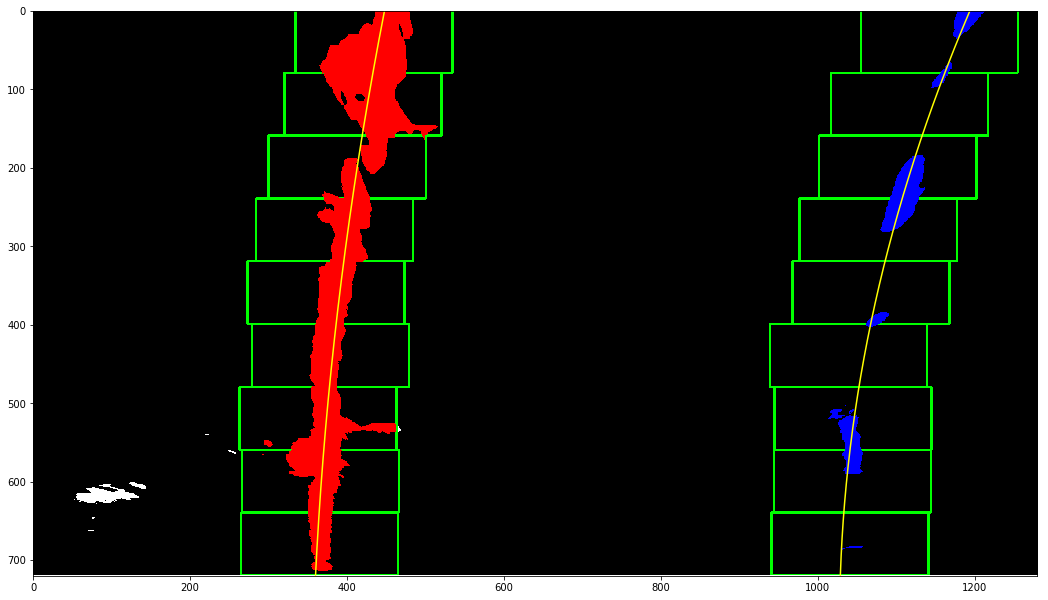

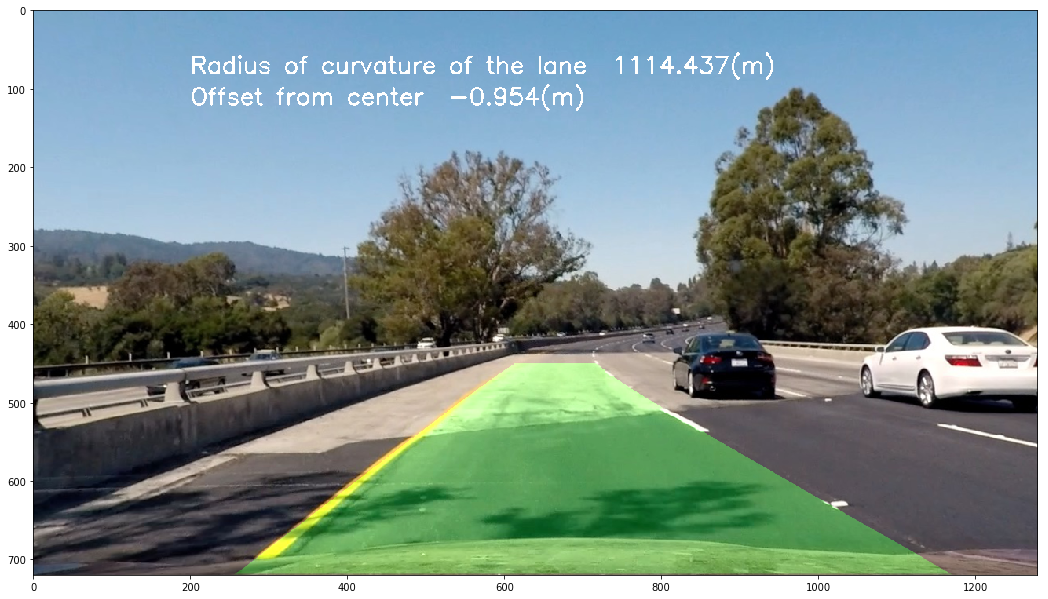

In [17]:
# Read image
image = mpimg.imread("test_images/test4.jpg")
# Undistort image
image = undistort(image, mtx_l, dist_l, show=False)

# Apply perspective transform
warped, M, Minv = perspective_transform(image, mtx_l, dist_l)
# Get the mask 
result_g, result_c = get_mask(warped)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Original', fontsize=18)
ax2.axis('off')
ax2.imshow(result_g,cmap='gray')
ax2.set_title('Perspective Transform', fontsize=18)

# Find lanes
out_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty  = find_lanes(result_g)
# Estimate curvature and offset
left_radius, right_radius, offset = compute_radius_offset(leftx, lefty, rightx, righty, image.shape)

radius = (left_radius + right_radius)/2
# Plot Result
plt.figure(figsize=(18,18))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Reproject polygon on the original image
result = draw_lines(image, result_g, left_fitx, right_fitx, ploty, Minv )
cv2.putText(result, 'Radius of curvature of the lane  {}(m)'.format(round(radius, 3)), (200,20*4),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2) 
cv2.putText(result, 'Offset from center  {}(m)'.format(round(offset,3)), (200, 20*6),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2) 
plt.figure(figsize=(18,18))
plt.imshow(result)

# Test on Video

In [7]:
import collections

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, isleft):
        self.isleft = isleft
        # was the line detected in the last iteration?
        self.detected = False 
        # second order polynomial 
        self.fit = None
        # Actual second order polynomial
        self.fit_actual = None
        # polygon points
        self.line_pts = []
        # line to draw
        self.line_draw = []
        # Queue with last detections
        self.fit_past = collections.deque(maxlen=10)
        # Frame counter:
        self.count = 0
        # Radius for display
        self.radius_disp = 0
        # x values of the last n fits of the line
        #self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        #self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #distance in meters of vehicle center from the line
        #self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        #self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        #self.allx = None  
        #y values for detected line pixels
        #self.ally = None
        
        
    def blind_search(self, binary_warped, out_img, nwindows = 9):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        if (self.isleft):
            x_base = np.argmax(histogram[:midpoint])
        else:
            x_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        x_current = x_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_x_low,win_y_low),(win_x_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
            # Append these indices to the lists
            lane_inds.append(good_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))


        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)

        # Extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 

        if np.sum(x) > 0: 
            # Fit a second order polynomial 
            self.fit = np.polyfit(y, x, 2)

            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            fitx = self.fit[0]*ploty**2 + self.fit[1]*ploty + self.fit[2]

            if (self.isleft):
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [255, 0, 0]
            else:
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [0, 0, 255]
            self.detected = True

            return fitx, x, y, ploty 
        else:
            self.detected = False # If no lane pixels were detected then perform blind search
            self.fit_past = []
            self.fit = []
            fitx = []
            x = []
            y = []
            ploty = []
            return fitx, x, y, ploty        
    
    def found_search(self, binary_warped, out_img):
    
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        lane_inds = ((nonzerox > (self.fit[0]*(nonzeroy**2) + self.fit[1]*nonzeroy + self.fit[2] - margin)) & (nonzerox < (self.fit[0]*(nonzeroy**2) + self.fit[1]*nonzeroy + self.fit[2] + margin))) 

        # Again, extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 
        
        if np.sum(x) > 0: 
            # Fit a second order polynomial
            self.fit = np.polyfit(y, x, 2)
            self.fit_actual = self.fit
            self.fit_past.append(self.fit)
            self.fit = np.array(self.fit_past).sum(axis=0)
            self.fit = self.fit/len(self.fit_past)
            
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            fitx = self.fit[0]*ploty**2 + self.fit[1]*ploty + self.fit[2]

            #window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            if (self.isleft):
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [255, 0, 0]
            else:
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            line_window1 = np.array([np.transpose(np.vstack([fitx-margin, ploty]))])
            line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx+margin, ploty])))])
            self.line_pts = np.hstack((line_window1, line_window2))
            
            fitx_actual = self.fit_actual[0]*ploty**2 + self.fit_actual[1]*ploty + self.fit_actual[2]

            line_window1 = np.array([np.transpose(np.vstack([fitx_actual-2, ploty]))])
            line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx_actual+2, ploty])))])
            self.line_draw = np.hstack((line_window1, line_window2))
            
            return fitx, x, y, ploty
        else:
            self.detected = False # If no lane pixels were detected then perform blind search
            self.fit_past = []
            self.fit = []
            fitx = []
            x = []
            y = []
            ploty = []
            return fitx, x, y, ploty

        
# Check if the curves are parallel       
def sanity_check(right_line, left_line, right_fitx,left_fitx, ploty, leftx, lefty, rightx, righty):
    pl_bot_real = (leftx[-1], lefty[-1])
    pr_bot_real = (rightx[-1], righty[-1])
    pl_top_real = (leftx[0], lefty[0])
    pr_top_real = (rightx[0], righty[0]) 

    pl_top = (right_fitx[0], ploty[0])
    pr_top = (left_fitx[0], ploty[0])
    pl_bot = (right_fitx[-1], ploty[-1])
    pr_bot = (left_fitx[-1], ploty[-1])     

    dist_bottom =  distance(pl_bot, pr_bot)
    dist_top =  distance(pl_top, pr_top)
    
    if abs(dist_bottom - dist_top) > 100:
        right_line.fit = right_line.fit_past[-1]
        left_line.fit = left_line.fit_past[-1]
    
    return pl_bot, pr_bot, pl_top, pr_top         

def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)


def draw_line_polygon(out_img, right_line_pts, left_line_pts, color = (0,255, 0)):
    window_img = np.zeros_like(out_img)
    if (len(left_line_pts)):
        cv2.fillPoly(window_img, np.int_([left_line_pts]), color)
    if (len(right_line_pts)):
        cv2.fillPoly(window_img, np.int_([right_line_pts]), color)
    return window_img
        


In [8]:
def process_image(image):
    # Rectify image
    image = undistort(image, mtx_l, dist_l, show=False)
    # Get mask
    result_g, result_c = get_mask(image)
    # Compute the perspective transform
    binary_warped, M, Minv = perspective_transform(result_g, mtx_l, dist_l)

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    if (left_line.detected == True):
        left_fitx, left_x, left_y, ploty  = left_line.found_search(binary_warped, out_img)
        
    if (left_line.detected == False):
        left_fitx, left_x, left_y, ploty  = left_line.blind_search(binary_warped, out_img)
        
    if (right_line.detected == True):
        right_fitx, right_x, right_y, ploty = right_line.found_search(binary_warped, out_img)
        
    if (right_line.detected == False):
        right_fitx, right_x, right_y, ploty = right_line.blind_search(binary_warped, out_img)
     
    if (right_line.detected & left_line.detected):
        # Get radius and offset
        left_radius, right_radius, offset = compute_radius_offset(left_x, left_y, right_x, right_y, image.shape)

        # Draw lines
        window_img = draw_line_polygon(out_img, right_line.line_pts, left_line.line_pts, color = (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        window_img = draw_line_polygon(out_img, right_line.line_draw, left_line.line_draw, color = (255,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.9, 0)
        
        pl_bottom, pr_bottom, pl_top, pr_top = sanity_check(right_line, left_line, right_fitx,left_fitx, ploty, left_x, left_y, right_x, right_y)
        
        # Draw result on the original image
        result = draw_lines(image, binary_warped, left_fitx, right_fitx, ploty, Minv)

        out_img_small = cv2.resize(out_img, (int(out_img.shape[1]/3.5),int(out_img.shape[0]/3.5)))

        x_offset=20
        y_offset=20
        result[y_offset:y_offset+out_img_small.shape[0], x_offset:x_offset+out_img_small.shape[1]] = out_img_small

        prev_radius = int((left_line.radius_of_curvature+right_line.radius_of_curvature)/2)
        radius = int((left_radius+right_radius)/2)
        radius = int((radius+prev_radius)/2)

        if left_line.count % 3 == 0:
            left_line.radius_disp = radius

        if left_line.count > 5:    
            cv2.putText(result, 'Radius of curvature of the lane  {}(m)'.format(left_line.radius_disp), (540,x_offset*4),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2) 
            cv2.putText(result, 'Offset from center  {}(m)'.format(round(offset,3)), (540, x_offset*6),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2) 
        left_line.radius_of_curvature = left_radius
        right_line.radius_of_curvature = right_radius
        left_line.count += 1
    else:
        result = image
    
    return result

In [10]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#del left_line
#del right_line

left_line = Line(True)
right_line = Line(False)

output = 'project_video_output_inverted_points_new_a.mp4'
clip2 = VideoFileClip('project_video.mp4')
output_clip = clip2.fl_image(process_image)
%time output_clip.write_videofile(output, audio=False)

0.438714285714
[MoviePy] >>>> Building video project_video_output_inverted_points_new_a.mp4
[MoviePy] Writing video project_video_output_inverted_points_new_a.mp4


  0%|          | 1/1261 [00:00<07:46,  2.70it/s]

-0.383214285714


  0%|          | 2/1261 [00:00<07:43,  2.72it/s]

-0.412285714286


  0%|          | 3/1261 [00:01<07:15,  2.89it/s]

-0.420214285714


  0%|          | 4/1261 [00:01<06:54,  3.03it/s]

-0.420214285714


  0%|          | 5/1261 [00:01<06:31,  3.21it/s]

-0.428142857143


  0%|          | 6/1261 [00:01<06:28,  3.23it/s]

-0.422857142857


  1%|          | 7/1261 [00:02<06:23,  3.27it/s]

-0.414928571429


  1%|          | 8/1261 [00:02<06:03,  3.45it/s]

-0.380571428571


  1%|          | 9/1261 [00:02<05:44,  3.64it/s]

-0.362071428571


  1%|          | 10/1261 [00:02<05:31,  3.78it/s]

-0.428142857143


  1%|          | 11/1261 [00:03<05:28,  3.80it/s]

-0.457214285714


  1%|          | 12/1261 [00:03<05:48,  3.59it/s]

-0.430785714286


  1%|          | 13/1261 [00:03<06:00,  3.46it/s]

-0.412285714286


  1%|          | 14/1261 [00:04<06:01,  3.45it/s]

-0.399071428571


  1%|          | 15/1261 [00:04<06:00,  3.45it/s]

-0.399071428571


  1%|▏         | 16/1261 [00:04<05:57,  3.48it/s]

-0.438714285714


  1%|▏         | 17/1261 [00:04<05:42,  3.63it/s]

-0.190285714286


  1%|▏         | 18/1261 [00:05<05:40,  3.65it/s]

-0.404357142857


  2%|▏         | 19/1261 [00:05<06:03,  3.42it/s]

-0.404357142857


  2%|▏         | 20/1261 [00:05<06:23,  3.24it/s]

-0.404357142857


  2%|▏         | 21/1261 [00:06<06:15,  3.30it/s]

-0.391142857143


  2%|▏         | 22/1261 [00:06<06:09,  3.35it/s]

-0.409642857143


  2%|▏         | 23/1261 [00:06<06:19,  3.26it/s]

-0.417571428571


  2%|▏         | 24/1261 [00:07<06:28,  3.19it/s]

-0.422857142857


  2%|▏         | 25/1261 [00:07<06:41,  3.08it/s]

-0.401714285714


  2%|▏         | 26/1261 [00:07<06:35,  3.12it/s]

-0.377928571429


  2%|▏         | 27/1261 [00:08<06:11,  3.32it/s]

-0.356785714286


  2%|▏         | 28/1261 [00:08<05:56,  3.46it/s]

-0.354142857143


  2%|▏         | 29/1261 [00:08<06:18,  3.25it/s]

-0.3885


  2%|▏         | 30/1261 [00:08<06:24,  3.20it/s]

-0.37


  2%|▏         | 31/1261 [00:09<06:21,  3.22it/s]

-0.367357142857


  3%|▎         | 32/1261 [00:09<06:04,  3.37it/s]

-0.383214285714


  3%|▎         | 33/1261 [00:09<06:01,  3.40it/s]

-0.346214285714


  3%|▎         | 34/1261 [00:10<06:04,  3.37it/s]

-0.319785714286


  3%|▎         | 35/1261 [00:10<06:21,  3.22it/s]

-0.333


  3%|▎         | 36/1261 [00:10<06:28,  3.15it/s]

-0.383214285714


  3%|▎         | 37/1261 [00:11<06:45,  3.02it/s]

-0.3885


  3%|▎         | 38/1261 [00:11<06:36,  3.08it/s]

-0.3515


  3%|▎         | 39/1261 [00:11<06:37,  3.07it/s]

-0.362071428571


  3%|▎         | 40/1261 [00:12<06:15,  3.25it/s]

-0.362071428571


  3%|▎         | 41/1261 [00:12<06:06,  3.33it/s]

-0.377928571429


  3%|▎         | 42/1261 [00:12<06:15,  3.24it/s]

-0.470428571429


  3%|▎         | 43/1261 [00:13<06:28,  3.14it/s]

-0.401714285714


  3%|▎         | 44/1261 [00:13<06:28,  3.13it/s]

-0.404357142857


  4%|▎         | 45/1261 [00:13<06:30,  3.11it/s]

-0.407


  4%|▎         | 46/1261 [00:13<06:09,  3.29it/s]

-0.346214285714


  4%|▎         | 47/1261 [00:14<05:59,  3.38it/s]

-0.396428571429


  4%|▍         | 48/1261 [00:14<05:45,  3.51it/s]

-0.396428571429


  4%|▍         | 49/1261 [00:14<06:09,  3.28it/s]

-0.420214285714


  4%|▍         | 50/1261 [00:15<06:16,  3.21it/s]

-0.430785714286


  4%|▍         | 51/1261 [00:15<06:28,  3.11it/s]

-0.3885


  4%|▍         | 52/1261 [00:15<06:39,  3.02it/s]

-0.380571428571


  4%|▍         | 53/1261 [00:16<06:47,  2.96it/s]

-0.377928571429


  4%|▍         | 54/1261 [00:16<06:45,  2.98it/s]

-0.372642857143


  4%|▍         | 55/1261 [00:16<06:48,  2.96it/s]

-0.393785714286


  4%|▍         | 56/1261 [00:17<06:46,  2.97it/s]

-0.3885


  5%|▍         | 57/1261 [00:17<06:44,  2.98it/s]

-0.380571428571


  5%|▍         | 58/1261 [00:17<06:34,  3.05it/s]

-0.396428571429


  5%|▍         | 59/1261 [00:18<06:22,  3.14it/s]

-0.359428571429


  5%|▍         | 60/1261 [00:18<06:13,  3.21it/s]

-0.325071428571


  5%|▍         | 61/1261 [00:18<06:06,  3.28it/s]

-0.319785714286


  5%|▍         | 62/1261 [00:19<05:58,  3.35it/s]

-0.356785714286


  5%|▍         | 63/1261 [00:19<05:56,  3.36it/s]

-0.322428571429


  5%|▌         | 64/1261 [00:19<06:00,  3.32it/s]

-0.333


  5%|▌         | 65/1261 [00:19<06:13,  3.20it/s]

-0.343571428571


  5%|▌         | 66/1261 [00:20<06:19,  3.15it/s]

-0.340928571429


  5%|▌         | 67/1261 [00:20<06:23,  3.11it/s]

-0.335642857143


  5%|▌         | 68/1261 [00:20<06:25,  3.10it/s]

-0.319785714286


  5%|▌         | 69/1261 [00:21<06:14,  3.18it/s]

-0.330357142857


  6%|▌         | 70/1261 [00:21<06:06,  3.25it/s]

-0.293357142857


  6%|▌         | 71/1261 [00:21<06:17,  3.15it/s]

-0.282785714286


  6%|▌         | 72/1261 [00:22<06:31,  3.04it/s]

-0.253714285714


  6%|▌         | 73/1261 [00:22<06:29,  3.05it/s]

-0.303928571429


  6%|▌         | 74/1261 [00:22<06:27,  3.06it/s]

-0.3145


  6%|▌         | 75/1261 [00:23<06:32,  3.02it/s]

-0.319785714286


  6%|▌         | 76/1261 [00:23<06:30,  3.03it/s]

-0.259


  6%|▌         | 77/1261 [00:23<06:24,  3.08it/s]

-0.266928571429


  6%|▌         | 78/1261 [00:24<06:03,  3.26it/s]

-0.285428571429


  6%|▋         | 79/1261 [00:24<05:50,  3.37it/s]

-0.285428571429


  6%|▋         | 80/1261 [00:24<05:42,  3.45it/s]

-0.282785714286


  6%|▋         | 81/1261 [00:24<05:35,  3.52it/s]

-0.2775


  7%|▋         | 82/1261 [00:25<05:27,  3.60it/s]

-0.272214285714


  7%|▋         | 83/1261 [00:25<05:32,  3.54it/s]

-0.272214285714


  7%|▋         | 84/1261 [00:25<05:45,  3.41it/s]

-0.224642857143


  7%|▋         | 85/1261 [00:26<05:54,  3.32it/s]

-0.253714285714


  7%|▋         | 86/1261 [00:26<05:46,  3.39it/s]

-0.285428571429


  7%|▋         | 87/1261 [00:26<05:39,  3.46it/s]

-0.264285714286


  7%|▋         | 88/1261 [00:26<05:34,  3.51it/s]

-0.214071428571


  7%|▋         | 89/1261 [00:27<05:33,  3.51it/s]

-0.222


  7%|▋         | 90/1261 [00:27<05:50,  3.34it/s]

-0.232571428571


  7%|▋         | 91/1261 [00:27<05:57,  3.28it/s]

-0.235214285714


  7%|▋         | 92/1261 [00:28<06:04,  3.21it/s]

-0.243142857143


  7%|▋         | 93/1261 [00:28<05:40,  3.43it/s]

-0.227285714286


  7%|▋         | 94/1261 [00:28<05:29,  3.54it/s]

-0.245785714286


  8%|▊         | 95/1261 [00:28<05:22,  3.61it/s]

-0.245785714286


  8%|▊         | 96/1261 [00:29<05:11,  3.74it/s]

-0.216714285714


  8%|▊         | 97/1261 [00:29<05:09,  3.76it/s]

-0.198214285714


  8%|▊         | 98/1261 [00:29<05:03,  3.84it/s]

-0.232571428571


  8%|▊         | 99/1261 [00:30<05:03,  3.83it/s]

-0.256357142857


  8%|▊         | 100/1261 [00:30<05:18,  3.65it/s]

-0.251071428571


  8%|▊         | 101/1261 [00:30<05:33,  3.48it/s]

-0.229928571429


  8%|▊         | 102/1261 [00:30<05:20,  3.62it/s]

-0.216714285714


  8%|▊         | 103/1261 [00:31<05:37,  3.43it/s]

-0.253714285714


  8%|▊         | 104/1261 [00:31<05:41,  3.39it/s]

-0.243142857143


  8%|▊         | 105/1261 [00:31<05:25,  3.55it/s]

-0.269571428571


  8%|▊         | 106/1261 [00:32<05:50,  3.30it/s]

-0.285428571429


  8%|▊         | 107/1261 [00:32<05:52,  3.28it/s]

-0.288071428571


  9%|▊         | 108/1261 [00:32<05:46,  3.33it/s]

-0.309214285714


  9%|▊         | 109/1261 [00:32<05:30,  3.49it/s]

-0.296


  9%|▊         | 110/1261 [00:33<05:41,  3.37it/s]

-0.2775


  9%|▉         | 111/1261 [00:33<05:54,  3.24it/s]

-0.253714285714


  9%|▉         | 112/1261 [00:33<06:05,  3.15it/s]

-0.3145


  9%|▉         | 113/1261 [00:34<06:29,  2.94it/s]

-0.266928571429


  9%|▉         | 114/1261 [00:34<06:15,  3.05it/s]

-0.298642857143


  9%|▉         | 115/1261 [00:34<05:59,  3.19it/s]

-0.319785714286


  9%|▉         | 116/1261 [00:35<05:54,  3.23it/s]

-0.330357142857


  9%|▉         | 117/1261 [00:35<05:41,  3.35it/s]

-0.335642857143


  9%|▉         | 118/1261 [00:35<05:36,  3.39it/s]

-0.317142857143


  9%|▉         | 119/1261 [00:36<05:36,  3.39it/s]

-0.319785714286


 10%|▉         | 120/1261 [00:36<05:28,  3.48it/s]

-0.338285714286


 10%|▉         | 121/1261 [00:36<05:16,  3.61it/s]

-0.317142857143


 10%|▉         | 122/1261 [00:36<05:11,  3.66it/s]

-0.346214285714


 10%|▉         | 123/1261 [00:37<05:35,  3.39it/s]

-0.319785714286


 10%|▉         | 124/1261 [00:37<05:30,  3.44it/s]

-0.356785714286


 10%|▉         | 125/1261 [00:37<05:26,  3.48it/s]

-0.385857142857


 10%|▉         | 126/1261 [00:38<05:31,  3.42it/s]

-0.317142857143


 10%|█         | 127/1261 [00:38<05:29,  3.44it/s]

-0.372642857143


 10%|█         | 128/1261 [00:38<05:31,  3.42it/s]

-0.375285714286


 10%|█         | 129/1261 [00:38<05:17,  3.57it/s]

-0.377928571429


 10%|█         | 130/1261 [00:39<05:04,  3.71it/s]

-0.399071428571


 10%|█         | 131/1261 [00:39<04:52,  3.87it/s]

-0.396428571429


 10%|█         | 132/1261 [00:39<04:48,  3.91it/s]

-0.383214285714


 11%|█         | 133/1261 [00:39<05:06,  3.68it/s]

-0.375285714286


 11%|█         | 134/1261 [00:40<05:14,  3.59it/s]

-0.338285714286


 11%|█         | 135/1261 [00:40<05:19,  3.52it/s]

-0.362071428571


 11%|█         | 136/1261 [00:40<05:31,  3.39it/s]

-0.343571428571


 11%|█         | 137/1261 [00:41<05:39,  3.31it/s]

-0.399071428571


 11%|█         | 138/1261 [00:41<05:49,  3.22it/s]

-0.401714285714


 11%|█         | 139/1261 [00:41<05:39,  3.30it/s]

-0.396428571429


 11%|█         | 140/1261 [00:42<05:22,  3.48it/s]

-0.399071428571


 11%|█         | 141/1261 [00:42<05:06,  3.65it/s]

-0.409642857143


 11%|█▏        | 142/1261 [00:42<04:56,  3.77it/s]

-0.417571428571


 11%|█▏        | 143/1261 [00:42<05:12,  3.57it/s]

-0.414928571429


 11%|█▏        | 144/1261 [00:43<05:17,  3.52it/s]

-0.414928571429


 11%|█▏        | 145/1261 [00:43<05:23,  3.45it/s]

-0.414928571429


 12%|█▏        | 146/1261 [00:43<05:44,  3.23it/s]

-0.375285714286


 12%|█▏        | 147/1261 [00:44<05:38,  3.29it/s]

-0.346214285714


 12%|█▏        | 148/1261 [00:44<05:35,  3.32it/s]

-0.375285714286


 12%|█▏        | 149/1261 [00:44<05:29,  3.37it/s]

-0.407


 12%|█▏        | 150/1261 [00:44<05:30,  3.36it/s]

-0.377928571429


 12%|█▏        | 151/1261 [00:45<05:36,  3.30it/s]

-0.362071428571


 12%|█▏        | 152/1261 [00:45<05:33,  3.33it/s]

-0.383214285714


 12%|█▏        | 153/1261 [00:45<05:19,  3.47it/s]

-0.385857142857


 12%|█▏        | 154/1261 [00:46<05:18,  3.47it/s]

-0.393785714286


 12%|█▏        | 155/1261 [00:46<05:41,  3.24it/s]

-0.404357142857


 12%|█▏        | 156/1261 [00:46<05:46,  3.19it/s]

-0.391142857143


 12%|█▏        | 157/1261 [00:47<05:26,  3.39it/s]

-0.3885


 13%|█▎        | 158/1261 [00:47<05:22,  3.42it/s]

-0.343571428571


 13%|█▎        | 159/1261 [00:47<05:26,  3.38it/s]

-0.354142857143


 13%|█▎        | 160/1261 [00:47<05:34,  3.29it/s]

-0.348857142857


 13%|█▎        | 161/1261 [00:48<05:26,  3.36it/s]

-0.306571428571


 13%|█▎        | 162/1261 [00:48<05:27,  3.35it/s]

-0.362071428571


 13%|█▎        | 163/1261 [00:48<05:27,  3.35it/s]

-0.3515


 13%|█▎        | 164/1261 [00:49<05:17,  3.45it/s]

-0.319785714286


 13%|█▎        | 165/1261 [00:49<05:02,  3.63it/s]

-0.309214285714


 13%|█▎        | 166/1261 [00:49<05:14,  3.48it/s]

-0.356785714286


 13%|█▎        | 167/1261 [00:49<05:18,  3.43it/s]

-0.333


 13%|█▎        | 168/1261 [00:50<05:27,  3.34it/s]

-0.333


 13%|█▎        | 169/1261 [00:50<05:11,  3.51it/s]

-0.362071428571


 13%|█▎        | 170/1261 [00:50<05:02,  3.61it/s]

-0.346214285714


 14%|█▎        | 171/1261 [00:51<05:09,  3.52it/s]

-0.346214285714


 14%|█▎        | 172/1261 [00:51<05:17,  3.43it/s]

-0.301285714286


 14%|█▎        | 173/1261 [00:51<05:11,  3.49it/s]

-0.319785714286


 14%|█▍        | 174/1261 [00:52<05:31,  3.28it/s]

-0.317142857143


 14%|█▍        | 175/1261 [00:52<05:37,  3.22it/s]

-0.330357142857


 14%|█▍        | 176/1261 [00:52<05:41,  3.18it/s]

-0.272214285714


 14%|█▍        | 177/1261 [00:52<05:32,  3.26it/s]

-0.2775


 14%|█▍        | 178/1261 [00:53<05:33,  3.24it/s]

-0.293357142857


 14%|█▍        | 179/1261 [00:53<05:31,  3.27it/s]

-0.309214285714


 14%|█▍        | 180/1261 [00:53<05:20,  3.38it/s]

-0.317142857143


 14%|█▍        | 181/1261 [00:54<05:03,  3.56it/s]

-0.2775


 14%|█▍        | 182/1261 [00:54<04:59,  3.60it/s]

-0.319785714286


 15%|█▍        | 183/1261 [00:54<05:09,  3.49it/s]

-0.251071428571


 15%|█▍        | 184/1261 [00:54<05:10,  3.47it/s]

-0.280142857143


 15%|█▍        | 185/1261 [00:55<05:07,  3.50it/s]

-0.3145


 15%|█▍        | 186/1261 [00:55<05:07,  3.50it/s]

-0.306571428571


 15%|█▍        | 187/1261 [00:55<05:08,  3.48it/s]

-0.306571428571


 15%|█▍        | 188/1261 [00:56<05:10,  3.46it/s]

-0.269571428571


 15%|█▍        | 189/1261 [00:56<05:12,  3.43it/s]

-0.301285714286


 15%|█▌        | 190/1261 [00:56<05:08,  3.47it/s]

-0.322428571429


 15%|█▌        | 191/1261 [00:56<04:56,  3.61it/s]

-0.333


 15%|█▌        | 192/1261 [00:57<04:44,  3.76it/s]

-0.343571428571


 15%|█▌        | 193/1261 [00:57<04:36,  3.87it/s]

-0.356785714286


 15%|█▌        | 194/1261 [00:57<04:29,  3.96it/s]

-0.3515


 15%|█▌        | 195/1261 [00:57<04:25,  4.02it/s]

-0.3515


 16%|█▌        | 196/1261 [00:58<04:19,  4.10it/s]

-0.2775


 16%|█▌        | 197/1261 [00:58<04:23,  4.04it/s]

-0.309214285714


 16%|█▌        | 198/1261 [00:58<04:35,  3.85it/s]

-0.317142857143


 16%|█▌        | 199/1261 [00:58<04:44,  3.74it/s]

-0.359428571429


 16%|█▌        | 200/1261 [00:59<04:50,  3.65it/s]

-0.372642857143


 16%|█▌        | 201/1261 [00:59<05:03,  3.49it/s]

-0.301285714286


 16%|█▌        | 202/1261 [00:59<05:04,  3.48it/s]

-0.343571428571


 16%|█▌        | 203/1261 [01:00<05:10,  3.41it/s]

-0.343571428571


 16%|█▌        | 204/1261 [01:00<05:18,  3.32it/s]

-0.346214285714


 16%|█▋        | 205/1261 [01:00<05:14,  3.36it/s]

-0.335642857143


 16%|█▋        | 206/1261 [01:01<05:30,  3.19it/s]

-0.340928571429


 16%|█▋        | 207/1261 [01:01<05:26,  3.23it/s]

-0.333


 16%|█▋        | 208/1261 [01:01<05:14,  3.35it/s]

-0.290714285714


 17%|█▋        | 209/1261 [01:01<04:53,  3.58it/s]

-0.280142857143


 17%|█▋        | 210/1261 [01:02<04:40,  3.75it/s]

-0.330357142857


 17%|█▋        | 211/1261 [01:02<04:32,  3.85it/s]

-0.346214285714


 17%|█▋        | 212/1261 [01:02<04:26,  3.93it/s]

-0.359428571429


 17%|█▋        | 213/1261 [01:02<04:42,  3.71it/s]

-0.3145


 17%|█▋        | 214/1261 [01:03<04:54,  3.55it/s]

-0.319785714286


 17%|█▋        | 215/1261 [01:03<04:56,  3.52it/s]

-0.322428571429


 17%|█▋        | 216/1261 [01:03<04:58,  3.51it/s]

-0.322428571429


 17%|█▋        | 217/1261 [01:04<04:53,  3.56it/s]

-0.285428571429


 17%|█▋        | 218/1261 [01:04<04:42,  3.70it/s]

-0.272214285714


 17%|█▋        | 219/1261 [01:04<04:29,  3.87it/s]

-0.285428571429


 17%|█▋        | 220/1261 [01:04<04:20,  3.99it/s]

-0.266928571429


 18%|█▊        | 221/1261 [01:05<04:15,  4.06it/s]

-0.266928571429


 18%|█▊        | 222/1261 [01:05<04:09,  4.16it/s]

-0.232571428571


 18%|█▊        | 223/1261 [01:05<04:06,  4.21it/s]

-0.293357142857


 18%|█▊        | 224/1261 [01:05<04:04,  4.24it/s]

-0.224642857143


 18%|█▊        | 225/1261 [01:05<03:57,  4.36it/s]

-0.256357142857


 18%|█▊        | 226/1261 [01:06<03:56,  4.37it/s]

-0.2405


 18%|█▊        | 227/1261 [01:06<03:58,  4.33it/s]

-0.248428571429


 18%|█▊        | 228/1261 [01:06<03:59,  4.31it/s]

-0.251071428571


 18%|█▊        | 229/1261 [01:06<03:59,  4.31it/s]

-0.256357142857


 18%|█▊        | 230/1261 [01:07<04:21,  3.95it/s]

-0.237857142857


 18%|█▊        | 231/1261 [01:07<04:44,  3.62it/s]

-0.256357142857


 18%|█▊        | 232/1261 [01:07<04:49,  3.56it/s]

-0.235214285714


 18%|█▊        | 233/1261 [01:08<04:51,  3.52it/s]

-0.177071428571


 19%|█▊        | 234/1261 [01:08<05:03,  3.38it/s]

-0.182357142857


 19%|█▊        | 235/1261 [01:08<05:01,  3.40it/s]

-0.214071428571


 19%|█▊        | 236/1261 [01:09<04:59,  3.42it/s]

-0.185


 19%|█▉        | 237/1261 [01:09<04:48,  3.55it/s]

-0.145357142857


 19%|█▉        | 238/1261 [01:09<04:47,  3.55it/s]

-0.185


 19%|█▉        | 239/1261 [01:09<04:48,  3.54it/s]

-0.182357142857


 19%|█▉        | 240/1261 [01:10<04:39,  3.66it/s]

-0.148


 19%|█▉        | 241/1261 [01:10<04:36,  3.68it/s]

-0.2035


 19%|█▉        | 242/1261 [01:10<04:45,  3.57it/s]

-0.200857142857


 19%|█▉        | 243/1261 [01:10<04:48,  3.53it/s]

-0.177071428571


 19%|█▉        | 244/1261 [01:11<04:55,  3.44it/s]

-0.171785714286


 19%|█▉        | 245/1261 [01:11<04:55,  3.44it/s]

-0.134785714286


 20%|█▉        | 246/1261 [01:11<04:49,  3.51it/s]

-0.103071428571


 20%|█▉        | 247/1261 [01:12<04:46,  3.53it/s]

-0.124214285714


 20%|█▉        | 248/1261 [01:12<04:47,  3.52it/s]

-0.171785714286


 20%|█▉        | 249/1261 [01:12<04:47,  3.52it/s]

-0.126857142857


 20%|█▉        | 250/1261 [01:12<04:35,  3.67it/s]

-0.145357142857


 20%|█▉        | 251/1261 [01:13<04:31,  3.72it/s]

-0.148


 20%|█▉        | 252/1261 [01:13<04:43,  3.56it/s]

-0.155928571429


 20%|██        | 253/1261 [01:13<04:45,  3.53it/s]

-0.161214285714


 20%|██        | 254/1261 [01:14<04:49,  3.48it/s]

-0.158571428571


 20%|██        | 255/1261 [01:14<04:41,  3.58it/s]

-0.1665


 20%|██        | 256/1261 [01:14<04:44,  3.54it/s]

-0.158571428571


 20%|██        | 257/1261 [01:14<04:52,  3.43it/s]

-0.103071428571


 20%|██        | 258/1261 [01:15<05:02,  3.32it/s]

-0.100428571429


 21%|██        | 259/1261 [01:15<04:56,  3.38it/s]

-0.161214285714


 21%|██        | 260/1261 [01:15<04:53,  3.41it/s]

-0.171785714286


 21%|██        | 261/1261 [01:16<04:51,  3.43it/s]

-0.185


 21%|██        | 262/1261 [01:16<04:56,  3.37it/s]

-0.137428571429


 21%|██        | 263/1261 [01:16<04:50,  3.43it/s]

-0.148


 21%|██        | 264/1261 [01:16<04:32,  3.66it/s]

-0.195571428571


 21%|██        | 265/1261 [01:17<04:30,  3.68it/s]

-0.179714285714


 21%|██        | 266/1261 [01:17<04:41,  3.53it/s]

-0.174428571429


 21%|██        | 267/1261 [01:17<04:44,  3.49it/s]

-0.195571428571


 21%|██▏       | 268/1261 [01:18<04:47,  3.45it/s]

-0.195571428571


 21%|██▏       | 269/1261 [01:18<04:39,  3.55it/s]

-0.190285714286


 21%|██▏       | 270/1261 [01:18<04:25,  3.73it/s]

-0.145357142857


 21%|██▏       | 271/1261 [01:18<04:27,  3.69it/s]

-0.177071428571


 22%|██▏       | 272/1261 [01:19<04:35,  3.58it/s]

-0.1665


 22%|██▏       | 273/1261 [01:19<04:38,  3.55it/s]

-0.198214285714


 22%|██▏       | 274/1261 [01:19<04:30,  3.65it/s]

-0.171785714286


 22%|██▏       | 275/1261 [01:19<04:19,  3.81it/s]

-0.140071428571


 22%|██▏       | 276/1261 [01:20<04:12,  3.90it/s]

-0.229928571429


 22%|██▏       | 277/1261 [01:20<04:05,  4.00it/s]

-0.237857142857


 22%|██▏       | 278/1261 [01:20<04:06,  3.98it/s]

-0.232571428571


 22%|██▏       | 279/1261 [01:21<04:18,  3.79it/s]

-0.237857142857


 22%|██▏       | 280/1261 [01:21<04:24,  3.71it/s]

-0.235214285714


 22%|██▏       | 281/1261 [01:21<04:35,  3.56it/s]

-0.216714285714


 22%|██▏       | 282/1261 [01:21<04:34,  3.57it/s]

-0.187642857143


 22%|██▏       | 283/1261 [01:22<04:27,  3.65it/s]

-0.179714285714


 23%|██▎       | 284/1261 [01:22<04:15,  3.82it/s]

-0.206142857143


 23%|██▎       | 285/1261 [01:22<04:07,  3.94it/s]

-0.227285714286


 23%|██▎       | 286/1261 [01:22<04:03,  4.00it/s]

-0.248428571429


 23%|██▎       | 287/1261 [01:23<03:58,  4.08it/s]

-0.264285714286


 23%|██▎       | 288/1261 [01:23<04:18,  3.76it/s]

-0.261642857143


 23%|██▎       | 289/1261 [01:23<04:27,  3.64it/s]

-0.280142857143


 23%|██▎       | 290/1261 [01:23<04:20,  3.73it/s]

-0.232571428571


 23%|██▎       | 291/1261 [01:24<04:12,  3.83it/s]

-0.251071428571


 23%|██▎       | 292/1261 [01:24<04:20,  3.71it/s]

-0.259


 23%|██▎       | 293/1261 [01:24<04:33,  3.54it/s]

-0.285428571429


 23%|██▎       | 294/1261 [01:25<04:33,  3.53it/s]

-0.266928571429


 23%|██▎       | 295/1261 [01:25<04:32,  3.55it/s]

-0.301285714286


 23%|██▎       | 296/1261 [01:25<04:24,  3.64it/s]

-0.290714285714


 24%|██▎       | 297/1261 [01:25<04:11,  3.83it/s]

-0.322428571429


 24%|██▎       | 298/1261 [01:26<04:21,  3.69it/s]

-0.269571428571


 24%|██▎       | 299/1261 [01:26<04:30,  3.56it/s]

-0.266928571429


 24%|██▍       | 300/1261 [01:26<04:33,  3.52it/s]

-0.309214285714


 24%|██▍       | 301/1261 [01:26<04:19,  3.70it/s]

-0.317142857143


 24%|██▍       | 302/1261 [01:27<04:08,  3.85it/s]

-0.311857142857


 24%|██▍       | 303/1261 [01:27<04:02,  3.95it/s]

-0.3145


 24%|██▍       | 304/1261 [01:27<03:57,  4.03it/s]

-0.272214285714


 24%|██▍       | 305/1261 [01:27<03:55,  4.06it/s]

-0.261642857143


 24%|██▍       | 306/1261 [01:28<03:53,  4.10it/s]

-0.235214285714


 24%|██▍       | 307/1261 [01:28<04:07,  3.85it/s]

-0.272214285714


 24%|██▍       | 308/1261 [01:28<04:15,  3.73it/s]

-0.2775


 25%|██▍       | 309/1261 [01:29<04:16,  3.71it/s]

-0.298642857143


 25%|██▍       | 310/1261 [01:29<04:15,  3.73it/s]

-0.306571428571


 25%|██▍       | 311/1261 [01:29<04:18,  3.67it/s]

-0.311857142857


 25%|██▍       | 312/1261 [01:29<04:27,  3.55it/s]

-0.3145


 25%|██▍       | 313/1261 [01:30<04:13,  3.74it/s]

-0.322428571429


 25%|██▍       | 314/1261 [01:30<04:18,  3.66it/s]

-0.301285714286


 25%|██▍       | 315/1261 [01:30<04:14,  3.72it/s]

-0.306571428571


 25%|██▌       | 316/1261 [01:30<04:17,  3.68it/s]

-0.303928571429


 25%|██▌       | 317/1261 [01:31<04:24,  3.58it/s]

-0.264285714286


 25%|██▌       | 318/1261 [01:31<04:19,  3.63it/s]

-0.253714285714


 25%|██▌       | 319/1261 [01:31<04:08,  3.79it/s]

-0.327714285714


 25%|██▌       | 320/1261 [01:32<04:23,  3.57it/s]

-0.338285714286


 25%|██▌       | 321/1261 [01:32<04:25,  3.54it/s]

-0.343571428571


 26%|██▌       | 322/1261 [01:32<04:24,  3.55it/s]

-0.285428571429


 26%|██▌       | 323/1261 [01:32<04:13,  3.70it/s]

-0.317142857143


 26%|██▌       | 324/1261 [01:33<04:01,  3.88it/s]

-0.327714285714


 26%|██▌       | 325/1261 [01:33<04:01,  3.88it/s]

-0.333


 26%|██▌       | 326/1261 [01:33<04:11,  3.71it/s]

-0.3145


 26%|██▌       | 327/1261 [01:33<04:15,  3.66it/s]

-0.285428571429


 26%|██▌       | 328/1261 [01:34<04:10,  3.72it/s]

-0.311857142857


 26%|██▌       | 329/1261 [01:34<04:18,  3.61it/s]

-0.282785714286


 26%|██▌       | 330/1261 [01:34<04:19,  3.58it/s]

-0.293357142857


 26%|██▌       | 331/1261 [01:35<04:25,  3.50it/s]

-0.293357142857


 26%|██▋       | 332/1261 [01:35<04:20,  3.56it/s]

-0.282785714286


 26%|██▋       | 333/1261 [01:35<04:07,  3.75it/s]

-0.335642857143


 26%|██▋       | 334/1261 [01:35<03:58,  3.88it/s]

-0.301285714286


 27%|██▋       | 335/1261 [01:36<03:52,  3.98it/s]

-0.325071428571


 27%|██▋       | 336/1261 [01:36<03:50,  4.02it/s]

-0.338285714286


 27%|██▋       | 337/1261 [01:36<03:53,  3.96it/s]

-0.346214285714


 27%|██▋       | 338/1261 [01:36<04:03,  3.80it/s]

-0.293357142857


 27%|██▋       | 339/1261 [01:37<04:12,  3.65it/s]

-0.338285714286


 27%|██▋       | 340/1261 [01:37<04:10,  3.68it/s]

-0.311857142857


 27%|██▋       | 341/1261 [01:37<04:00,  3.82it/s]

-0.335642857143


 27%|██▋       | 342/1261 [01:37<04:13,  3.62it/s]

-0.3145


 27%|██▋       | 343/1261 [01:38<04:17,  3.57it/s]

-0.348857142857


 27%|██▋       | 344/1261 [01:38<04:16,  3.57it/s]

-0.2775


 27%|██▋       | 345/1261 [01:38<04:14,  3.59it/s]

-0.298642857143


 27%|██▋       | 346/1261 [01:39<04:21,  3.50it/s]

-0.322428571429


 28%|██▊       | 347/1261 [01:39<04:23,  3.47it/s]

-0.303928571429


 28%|██▊       | 348/1261 [01:39<04:24,  3.45it/s]

-0.354142857143


 28%|██▊       | 349/1261 [01:39<04:24,  3.45it/s]

-0.359428571429


 28%|██▊       | 350/1261 [01:40<04:26,  3.42it/s]

-0.346214285714


 28%|██▊       | 351/1261 [01:40<04:17,  3.54it/s]

-0.343571428571


 28%|██▊       | 352/1261 [01:40<04:10,  3.62it/s]

-0.319785714286


 28%|██▊       | 353/1261 [01:41<04:13,  3.59it/s]

-0.303928571429


 28%|██▊       | 354/1261 [01:41<04:13,  3.58it/s]

-0.309214285714


 28%|██▊       | 355/1261 [01:41<04:12,  3.59it/s]

-0.354142857143


 28%|██▊       | 356/1261 [01:41<04:07,  3.66it/s]

-0.335642857143


 28%|██▊       | 357/1261 [01:42<03:55,  3.84it/s]

-0.301285714286


 28%|██▊       | 358/1261 [01:42<03:55,  3.83it/s]

-0.306571428571


 28%|██▊       | 359/1261 [01:42<04:04,  3.69it/s]

-0.338285714286


 29%|██▊       | 360/1261 [01:42<04:07,  3.64it/s]

-0.317142857143


 29%|██▊       | 361/1261 [01:43<04:07,  3.63it/s]

-0.325071428571


 29%|██▊       | 362/1261 [01:43<03:56,  3.81it/s]

-0.325071428571


 29%|██▉       | 363/1261 [01:43<04:11,  3.57it/s]

-0.298642857143


 29%|██▉       | 364/1261 [01:44<04:10,  3.58it/s]

-0.322428571429


 29%|██▉       | 365/1261 [01:44<04:12,  3.55it/s]

-0.327714285714


 29%|██▉       | 366/1261 [01:44<04:03,  3.68it/s]

-0.3515


 29%|██▉       | 367/1261 [01:44<03:52,  3.84it/s]

-0.354142857143


 29%|██▉       | 368/1261 [01:45<03:52,  3.84it/s]

-0.354142857143


 29%|██▉       | 369/1261 [01:45<04:01,  3.70it/s]

-0.330357142857


 29%|██▉       | 370/1261 [01:45<04:11,  3.54it/s]

-0.3515


 29%|██▉       | 371/1261 [01:45<04:14,  3.49it/s]

-0.319785714286


 30%|██▉       | 372/1261 [01:46<04:16,  3.47it/s]

-0.322428571429


 30%|██▉       | 373/1261 [01:46<04:11,  3.54it/s]

-0.348857142857


 30%|██▉       | 374/1261 [01:46<04:06,  3.60it/s]

-0.306571428571


 30%|██▉       | 375/1261 [01:47<04:14,  3.48it/s]

-0.296


 30%|██▉       | 376/1261 [01:47<04:20,  3.40it/s]

-0.303928571429


 30%|██▉       | 377/1261 [01:47<04:19,  3.41it/s]

-0.272214285714


 30%|██▉       | 378/1261 [01:48<04:15,  3.45it/s]

-0.322428571429


 30%|███       | 379/1261 [01:48<04:00,  3.66it/s]

-0.306571428571


 30%|███       | 380/1261 [01:48<04:09,  3.53it/s]

-0.288071428571


 30%|███       | 381/1261 [01:48<04:11,  3.50it/s]

-0.333


 30%|███       | 382/1261 [01:49<04:06,  3.56it/s]

-0.293357142857


 30%|███       | 383/1261 [01:49<03:53,  3.76it/s]

-0.261642857143


 30%|███       | 384/1261 [01:49<03:44,  3.91it/s]

-0.309214285714


 31%|███       | 385/1261 [01:49<03:43,  3.92it/s]

-0.3145


 31%|███       | 386/1261 [01:50<03:51,  3.78it/s]

-0.288071428571


 31%|███       | 387/1261 [01:50<03:58,  3.67it/s]

-0.280142857143


 31%|███       | 388/1261 [01:50<03:55,  3.70it/s]

-0.290714285714


 31%|███       | 389/1261 [01:50<03:48,  3.81it/s]

-0.282785714286


 31%|███       | 390/1261 [01:51<03:41,  3.93it/s]

-0.298642857143


 31%|███       | 391/1261 [01:51<03:38,  3.98it/s]

-0.293357142857


 31%|███       | 392/1261 [01:51<03:34,  4.06it/s]

-0.285428571429


 31%|███       | 393/1261 [01:51<03:39,  3.95it/s]

-0.335642857143


 31%|███       | 394/1261 [01:52<03:50,  3.76it/s]

-0.256357142857


 31%|███▏      | 395/1261 [01:52<03:55,  3.68it/s]

-0.256357142857


 31%|███▏      | 396/1261 [01:52<03:58,  3.63it/s]

-0.303928571429


 31%|███▏      | 397/1261 [01:53<04:05,  3.51it/s]

-0.261642857143


 32%|███▏      | 398/1261 [01:53<04:07,  3.48it/s]

-0.280142857143


 32%|███▏      | 399/1261 [01:53<04:06,  3.50it/s]

-0.280142857143


 32%|███▏      | 400/1261 [01:53<03:54,  3.67it/s]

-0.280142857143


 32%|███▏      | 401/1261 [01:54<03:47,  3.79it/s]

-0.274857142857


 32%|███▏      | 402/1261 [01:54<03:39,  3.92it/s]

-0.285428571429


 32%|███▏      | 403/1261 [01:54<03:33,  4.02it/s]

-0.251071428571


 32%|███▏      | 404/1261 [01:54<03:29,  4.09it/s]

-0.272214285714


 32%|███▏      | 405/1261 [01:55<03:31,  4.04it/s]

-0.269571428571


 32%|███▏      | 406/1261 [01:55<03:42,  3.84it/s]

-0.253714285714


 32%|███▏      | 407/1261 [01:55<03:48,  3.74it/s]

-0.256357142857


 32%|███▏      | 408/1261 [01:55<03:47,  3.74it/s]

-0.245785714286


 32%|███▏      | 409/1261 [01:56<03:41,  3.85it/s]

-0.256357142857


 33%|███▎      | 410/1261 [01:56<03:34,  3.97it/s]

-0.264285714286


 33%|███▎      | 411/1261 [01:56<03:33,  3.97it/s]

-0.251071428571


 33%|███▎      | 412/1261 [01:56<03:42,  3.81it/s]

-0.261642857143


 33%|███▎      | 413/1261 [01:57<03:53,  3.63it/s]

-0.253714285714


 33%|███▎      | 414/1261 [01:57<04:03,  3.48it/s]

-0.214071428571


 33%|███▎      | 415/1261 [01:57<04:04,  3.46it/s]

-0.251071428571


 33%|███▎      | 416/1261 [01:58<04:04,  3.46it/s]

-0.190285714286


 33%|███▎      | 417/1261 [01:58<03:59,  3.53it/s]

-0.235214285714


 33%|███▎      | 418/1261 [01:58<04:02,  3.48it/s]

-0.224642857143


 33%|███▎      | 419/1261 [01:59<04:00,  3.50it/s]

-0.227285714286


 33%|███▎      | 420/1261 [01:59<04:00,  3.50it/s]

-0.232571428571


 33%|███▎      | 421/1261 [01:59<04:06,  3.40it/s]

-0.206142857143


 33%|███▎      | 422/1261 [01:59<04:18,  3.25it/s]

-0.200857142857


 34%|███▎      | 423/1261 [02:00<04:12,  3.32it/s]

-0.219357142857


 34%|███▎      | 424/1261 [02:00<04:10,  3.34it/s]

-0.214071428571


 34%|███▎      | 425/1261 [02:00<03:55,  3.54it/s]

-0.216714285714


 34%|███▍      | 426/1261 [02:01<03:49,  3.63it/s]

-0.171785714286


 34%|███▍      | 427/1261 [02:01<03:53,  3.58it/s]

-0.169142857143


 34%|███▍      | 428/1261 [02:01<03:59,  3.48it/s]

-0.171785714286


 34%|███▍      | 429/1261 [02:01<03:57,  3.50it/s]

-0.200857142857


 34%|███▍      | 430/1261 [02:02<03:56,  3.52it/s]

-0.145357142857


 34%|███▍      | 431/1261 [02:02<04:00,  3.46it/s]

-0.185


 34%|███▍      | 432/1261 [02:02<04:05,  3.38it/s]

-0.174428571429


 34%|███▍      | 433/1261 [02:03<04:03,  3.41it/s]

-0.198214285714


 34%|███▍      | 434/1261 [02:03<04:06,  3.35it/s]

-0.174428571429


 34%|███▍      | 435/1261 [02:03<04:05,  3.37it/s]

-0.185


 35%|███▍      | 436/1261 [02:03<04:05,  3.36it/s]

-0.179714285714


 35%|███▍      | 437/1261 [02:04<03:56,  3.48it/s]

-0.163857142857


 35%|███▍      | 438/1261 [02:04<03:46,  3.64it/s]

-0.163857142857


 35%|███▍      | 439/1261 [02:04<04:02,  3.39it/s]

-0.118928571429


 35%|███▍      | 440/1261 [02:05<03:52,  3.54it/s]

-0.148


 35%|███▍      | 441/1261 [02:05<04:01,  3.40it/s]

-0.153285714286


 35%|███▌      | 442/1261 [02:05<04:01,  3.39it/s]

-0.153285714286


 35%|███▌      | 443/1261 [02:05<03:58,  3.43it/s]

-0.155928571429


 35%|███▌      | 444/1261 [02:06<03:54,  3.48it/s]

-0.171785714286


 35%|███▌      | 445/1261 [02:06<03:38,  3.73it/s]

-0.161214285714


 35%|███▌      | 446/1261 [02:06<03:31,  3.86it/s]

-0.148


 35%|███▌      | 447/1261 [02:07<03:43,  3.63it/s]

-0.153285714286


 36%|███▌      | 448/1261 [02:07<03:51,  3.51it/s]

-0.148


 36%|███▌      | 449/1261 [02:07<04:02,  3.35it/s]

-0.153285714286


 36%|███▌      | 450/1261 [02:07<04:04,  3.32it/s]

-0.153285714286


 36%|███▌      | 451/1261 [02:08<04:05,  3.30it/s]

-0.153285714286


 36%|███▌      | 452/1261 [02:08<04:04,  3.31it/s]

-0.150642857143


 36%|███▌      | 453/1261 [02:08<03:59,  3.37it/s]

-0.153285714286


 36%|███▌      | 454/1261 [02:09<03:56,  3.41it/s]

-0.140071428571


 36%|███▌      | 455/1261 [02:09<03:56,  3.40it/s]

-0.148


 36%|███▌      | 456/1261 [02:09<03:53,  3.44it/s]

-0.148


 36%|███▌      | 457/1261 [02:10<03:50,  3.49it/s]

-0.150642857143


 36%|███▋      | 458/1261 [02:10<03:49,  3.50it/s]

-0.153285714286


 36%|███▋      | 459/1261 [02:10<03:44,  3.57it/s]

-0.158571428571


 36%|███▋      | 460/1261 [02:10<03:38,  3.67it/s]

-0.150642857143


 37%|███▋      | 461/1261 [02:11<03:51,  3.46it/s]

-0.108357142857


 37%|███▋      | 462/1261 [02:11<03:52,  3.44it/s]

-0.0925


 37%|███▋      | 463/1261 [02:11<04:00,  3.32it/s]

-0.124214285714


 37%|███▋      | 464/1261 [02:12<03:59,  3.33it/s]

-0.171785714286


 37%|███▋      | 465/1261 [02:12<03:55,  3.39it/s]

-0.126857142857


 37%|███▋      | 466/1261 [02:12<03:55,  3.38it/s]

-0.153285714286


 37%|███▋      | 467/1261 [02:12<03:54,  3.39it/s]

-0.148


 37%|███▋      | 468/1261 [02:13<03:53,  3.40it/s]

-0.158571428571


 37%|███▋      | 469/1261 [02:13<03:54,  3.38it/s]

-0.158571428571


 37%|███▋      | 470/1261 [02:13<03:49,  3.45it/s]

-0.150642857143


 37%|███▋      | 471/1261 [02:14<03:47,  3.47it/s]

-0.153285714286


 37%|███▋      | 472/1261 [02:14<03:53,  3.38it/s]

-0.142714285714


 38%|███▊      | 473/1261 [02:14<04:00,  3.28it/s]

-0.116285714286


 38%|███▊      | 474/1261 [02:15<03:54,  3.36it/s]

-0.118928571429


 38%|███▊      | 475/1261 [02:15<03:50,  3.41it/s]

-0.116285714286


 38%|███▊      | 476/1261 [02:15<03:41,  3.54it/s]

-0.1665


 38%|███▊      | 477/1261 [02:15<03:43,  3.50it/s]

-0.187642857143


 38%|███▊      | 478/1261 [02:16<03:45,  3.48it/s]

-0.161214285714


 38%|███▊      | 479/1261 [02:16<03:43,  3.50it/s]

-0.161214285714


 38%|███▊      | 480/1261 [02:16<03:49,  3.41it/s]

-0.190285714286


 38%|███▊      | 481/1261 [02:17<03:50,  3.38it/s]

-0.192928571429


 38%|███▊      | 482/1261 [02:17<03:49,  3.39it/s]

-0.185


 38%|███▊      | 483/1261 [02:17<03:55,  3.30it/s]

-0.190285714286


 38%|███▊      | 484/1261 [02:17<03:56,  3.29it/s]

-0.161214285714


 38%|███▊      | 485/1261 [02:18<03:56,  3.28it/s]

-0.161214285714


 39%|███▊      | 486/1261 [02:18<03:48,  3.39it/s]

-0.148


 39%|███▊      | 487/1261 [02:18<03:40,  3.51it/s]

-0.142714285714


 39%|███▊      | 488/1261 [02:19<03:42,  3.47it/s]

-0.187642857143


 39%|███▉      | 489/1261 [02:19<03:43,  3.45it/s]

-0.182357142857


 39%|███▉      | 490/1261 [02:19<03:42,  3.46it/s]

-0.179714285714


 39%|███▉      | 491/1261 [02:19<03:49,  3.36it/s]

-0.192928571429


 39%|███▉      | 492/1261 [02:20<03:56,  3.25it/s]

-0.187642857143


 39%|███▉      | 493/1261 [02:20<03:51,  3.31it/s]

-0.182357142857


 39%|███▉      | 494/1261 [02:20<03:51,  3.31it/s]

-0.198214285714


 39%|███▉      | 495/1261 [02:21<03:40,  3.47it/s]

-0.2035


 39%|███▉      | 496/1261 [02:21<03:32,  3.59it/s]

-0.185


 39%|███▉      | 497/1261 [02:21<03:38,  3.50it/s]

-0.134785714286


 39%|███▉      | 498/1261 [02:22<03:40,  3.46it/s]

-0.132142857143


 40%|███▉      | 499/1261 [02:22<03:38,  3.48it/s]

-0.200857142857


 40%|███▉      | 500/1261 [02:22<03:33,  3.56it/s]

-0.153285714286


 40%|███▉      | 501/1261 [02:22<03:40,  3.45it/s]

-0.198214285714


 40%|███▉      | 502/1261 [02:23<03:41,  3.43it/s]

-0.224642857143


 40%|███▉      | 503/1261 [02:23<03:41,  3.43it/s]

-0.2035


 40%|███▉      | 504/1261 [02:23<03:37,  3.48it/s]

-0.192928571429


 40%|████      | 505/1261 [02:23<03:25,  3.69it/s]

-0.192928571429


 40%|████      | 506/1261 [02:24<03:35,  3.50it/s]

-0.200857142857


 40%|████      | 507/1261 [02:24<03:36,  3.49it/s]

-0.224642857143


 40%|████      | 508/1261 [02:24<03:37,  3.46it/s]

-0.192928571429


 40%|████      | 509/1261 [02:25<03:31,  3.55it/s]

-0.2405


 40%|████      | 510/1261 [02:25<03:19,  3.76it/s]

-0.232571428571


 41%|████      | 511/1261 [02:25<03:27,  3.62it/s]

-0.237857142857


 41%|████      | 512/1261 [02:26<03:37,  3.45it/s]

-0.232571428571


 41%|████      | 513/1261 [02:26<03:38,  3.42it/s]

-0.145357142857


 41%|████      | 514/1261 [02:26<03:38,  3.42it/s]

-0.137428571429


 41%|████      | 515/1261 [02:26<03:26,  3.61it/s]

-0.171785714286


 41%|████      | 516/1261 [02:27<03:28,  3.57it/s]

-0.195571428571


 41%|████      | 517/1261 [02:27<03:31,  3.52it/s]

-0.200857142857


 41%|████      | 518/1261 [02:27<03:42,  3.33it/s]

-0.174428571429


 41%|████      | 519/1261 [02:28<03:55,  3.15it/s]

-0.198214285714


 41%|████      | 520/1261 [02:28<03:54,  3.17it/s]

-0.185


 41%|████▏     | 521/1261 [02:28<03:51,  3.19it/s]

-0.153285714286


 41%|████▏     | 522/1261 [02:29<03:43,  3.30it/s]

-0.163857142857


 41%|████▏     | 523/1261 [02:29<03:41,  3.33it/s]

-0.158571428571


 42%|████▏     | 524/1261 [02:29<03:39,  3.36it/s]

-0.200857142857


 42%|████▏     | 525/1261 [02:29<03:36,  3.39it/s]

-0.208785714286


 42%|████▏     | 526/1261 [02:30<03:33,  3.45it/s]

-0.195571428571


 42%|████▏     | 527/1261 [02:30<03:32,  3.46it/s]

-0.195571428571


 42%|████▏     | 528/1261 [02:30<03:36,  3.39it/s]

-0.195571428571


 42%|████▏     | 529/1261 [02:31<03:38,  3.35it/s]

-0.190285714286


 42%|████▏     | 530/1261 [02:31<03:39,  3.34it/s]

-0.192928571429


 42%|████▏     | 531/1261 [02:31<03:39,  3.33it/s]

-0.185


 42%|████▏     | 532/1261 [02:31<03:37,  3.35it/s]

-0.171785714286


 42%|████▏     | 533/1261 [02:32<03:32,  3.42it/s]

-0.219357142857


 42%|████▏     | 534/1261 [02:32<03:36,  3.36it/s]

-0.219357142857


 42%|████▏     | 535/1261 [02:32<03:34,  3.39it/s]

-0.224642857143


 43%|████▎     | 536/1261 [02:33<03:29,  3.46it/s]

-0.195571428571


 43%|████▎     | 537/1261 [02:33<03:21,  3.59it/s]

-0.200857142857


 43%|████▎     | 538/1261 [02:33<03:31,  3.42it/s]

-0.229928571429


 43%|████▎     | 539/1261 [02:33<03:33,  3.38it/s]

-0.198214285714


 43%|████▎     | 540/1261 [02:34<03:37,  3.32it/s]

-0.227285714286


 43%|████▎     | 541/1261 [02:34<03:44,  3.21it/s]

-0.190285714286


 43%|████▎     | 542/1261 [02:34<03:39,  3.27it/s]

-0.214071428571


 43%|████▎     | 543/1261 [02:35<03:35,  3.33it/s]

-0.185


 43%|████▎     | 544/1261 [02:35<03:20,  3.58it/s]

-0.208785714286


 43%|████▎     | 545/1261 [02:35<03:21,  3.55it/s]

-0.214071428571


 43%|████▎     | 546/1261 [02:36<03:21,  3.56it/s]

-0.208785714286


 43%|████▎     | 547/1261 [02:36<03:21,  3.54it/s]

-0.2035


 43%|████▎     | 548/1261 [02:36<03:18,  3.60it/s]

-0.219357142857


 44%|████▎     | 549/1261 [02:36<03:22,  3.52it/s]

-0.214071428571


 44%|████▎     | 550/1261 [02:37<03:23,  3.50it/s]

-0.237857142857


 44%|████▎     | 551/1261 [02:37<03:22,  3.51it/s]

-0.214071428571


 44%|████▍     | 552/1261 [02:37<03:23,  3.49it/s]

-0.208785714286


 44%|████▍     | 553/1261 [02:38<03:21,  3.51it/s]

-0.214071428571


 44%|████▍     | 554/1261 [02:38<03:24,  3.46it/s]

-0.216714285714


 44%|████▍     | 555/1261 [02:38<03:20,  3.52it/s]

-0.206142857143


 44%|████▍     | 556/1261 [02:38<03:08,  3.75it/s]

-0.211428571429


 44%|████▍     | 557/1261 [02:39<03:01,  3.88it/s]

-0.192928571429


 44%|████▍     | 558/1261 [02:39<02:58,  3.95it/s]

-0.2405


 44%|████▍     | 559/1261 [02:39<03:06,  3.76it/s]

-0.256357142857


 44%|████▍     | 560/1261 [02:39<03:17,  3.56it/s]

-0.264285714286


 44%|████▍     | 561/1261 [02:40<03:16,  3.57it/s]

-0.243142857143


 45%|████▍     | 562/1261 [02:40<03:11,  3.65it/s]

-0.229928571429


 45%|████▍     | 563/1261 [02:40<03:00,  3.86it/s]

-0.198214285714


 45%|████▍     | 564/1261 [02:40<03:08,  3.71it/s]

-0.198214285714


 45%|████▍     | 565/1261 [02:41<03:09,  3.66it/s]

-0.158571428571


 45%|████▍     | 566/1261 [02:41<03:12,  3.62it/s]

-0.177071428571


 45%|████▍     | 567/1261 [02:41<03:13,  3.59it/s]

-0.216714285714


 45%|████▌     | 568/1261 [02:42<03:17,  3.52it/s]

-0.227285714286


 45%|████▌     | 569/1261 [02:42<03:18,  3.49it/s]

-0.192928571429


 45%|████▌     | 570/1261 [02:42<03:18,  3.49it/s]

-0.216714285714


 45%|████▌     | 571/1261 [02:42<03:20,  3.45it/s]

-0.200857142857


 45%|████▌     | 572/1261 [02:43<03:26,  3.33it/s]

-0.219357142857


 45%|████▌     | 573/1261 [02:43<03:24,  3.37it/s]

-0.208785714286


 46%|████▌     | 574/1261 [02:43<03:19,  3.45it/s]

-0.251071428571


 46%|████▌     | 575/1261 [02:44<03:07,  3.65it/s]

-0.248428571429


 46%|████▌     | 576/1261 [02:44<03:01,  3.78it/s]

-0.245785714286


 46%|████▌     | 577/1261 [02:44<02:56,  3.88it/s]

-0.229928571429


 46%|████▌     | 578/1261 [02:44<02:54,  3.92it/s]

-0.224642857143


 46%|████▌     | 579/1261 [02:45<02:47,  4.07it/s]

-0.243142857143


 46%|████▌     | 580/1261 [02:45<02:47,  4.07it/s]

-0.266928571429


 46%|████▌     | 581/1261 [02:45<02:46,  4.08it/s]

-0.224642857143


 46%|████▌     | 582/1261 [02:45<02:43,  4.16it/s]

-0.216714285714


 46%|████▌     | 583/1261 [02:46<02:41,  4.19it/s]

-0.200857142857


 46%|████▋     | 584/1261 [02:46<02:39,  4.24it/s]

-0.214071428571


 46%|████▋     | 585/1261 [02:46<02:37,  4.29it/s]

-0.2035


 46%|████▋     | 586/1261 [02:46<02:51,  3.95it/s]

-0.222


 47%|████▋     | 587/1261 [02:47<02:56,  3.81it/s]

-0.216714285714


 47%|████▋     | 588/1261 [02:47<02:59,  3.74it/s]

-0.232571428571


 47%|████▋     | 589/1261 [02:47<02:58,  3.77it/s]

-0.251071428571


 47%|████▋     | 590/1261 [02:47<03:03,  3.66it/s]

-0.219357142857


 47%|████▋     | 591/1261 [02:48<03:06,  3.59it/s]

-0.251071428571


 47%|████▋     | 592/1261 [02:48<03:12,  3.48it/s]

-0.243142857143


 47%|████▋     | 593/1261 [02:48<03:17,  3.38it/s]

-0.211428571429


 47%|████▋     | 594/1261 [02:49<03:14,  3.44it/s]

-0.2035


 47%|████▋     | 595/1261 [02:49<03:10,  3.49it/s]

-0.190285714286


 47%|████▋     | 596/1261 [02:49<02:59,  3.70it/s]

-0.195571428571


 47%|████▋     | 597/1261 [02:49<02:57,  3.74it/s]

-0.192928571429


 47%|████▋     | 598/1261 [02:50<02:59,  3.68it/s]

-0.148


 48%|████▊     | 599/1261 [02:50<03:09,  3.49it/s]

-0.179714285714


 48%|████▊     | 600/1261 [02:50<03:09,  3.49it/s]

-0.190285714286


 48%|████▊     | 601/1261 [02:50<02:55,  3.76it/s]

-0.195571428571


 48%|████▊     | 602/1261 [02:51<02:50,  3.86it/s]

-0.142714285714


 48%|████▊     | 603/1261 [02:51<02:54,  3.77it/s]

-0.142714285714


 48%|████▊     | 604/1261 [02:51<03:00,  3.63it/s]

-0.140071428571


 48%|████▊     | 605/1261 [02:52<03:05,  3.54it/s]

-0.185


 48%|████▊     | 606/1261 [02:52<03:03,  3.56it/s]

-0.161214285714


 48%|████▊     | 607/1261 [02:52<03:03,  3.57it/s]

-0.155928571429


 48%|████▊     | 608/1261 [02:52<02:53,  3.77it/s]

-0.140071428571


 48%|████▊     | 609/1261 [02:53<02:45,  3.95it/s]

-0.121571428571


 48%|████▊     | 610/1261 [02:53<02:41,  4.02it/s]

-0.126857142857


 48%|████▊     | 611/1261 [02:53<02:51,  3.79it/s]

-0.108357142857


 49%|████▊     | 612/1261 [02:53<02:55,  3.70it/s]

-0.111


 49%|████▊     | 613/1261 [02:54<02:57,  3.65it/s]

-0.0660714285714


 49%|████▊     | 614/1261 [02:54<02:53,  3.72it/s]

-0.0951428571429


 49%|████▉     | 615/1261 [02:54<02:58,  3.63it/s]

-0.0925


 49%|████▉     | 616/1261 [02:55<02:57,  3.64it/s]

-0.0872142857143


 49%|████▉     | 617/1261 [02:55<02:57,  3.64it/s]

-0.0264285714286


 49%|████▉     | 618/1261 [02:55<02:48,  3.81it/s]

-0.0607857142857


 49%|████▉     | 619/1261 [02:55<02:43,  3.93it/s]

-0.0660714285714


 49%|████▉     | 620/1261 [02:56<02:39,  4.01it/s]

-0.0158571428571


 49%|████▉     | 621/1261 [02:56<02:38,  4.05it/s]

-0.0634285714286


 49%|████▉     | 622/1261 [02:56<02:50,  3.74it/s]

-0.0422857142857


 49%|████▉     | 623/1261 [02:56<03:00,  3.54it/s]

-0.0422857142857


 49%|████▉     | 624/1261 [02:57<03:01,  3.52it/s]

-0.0396428571429


 50%|████▉     | 625/1261 [02:57<02:56,  3.60it/s]

-0.037


 50%|████▉     | 626/1261 [02:57<02:51,  3.71it/s]

-0.0422857142857


 50%|████▉     | 627/1261 [02:57<02:52,  3.68it/s]

-0.0660714285714


 50%|████▉     | 628/1261 [02:58<02:45,  3.82it/s]

-0.074


 50%|████▉     | 629/1261 [02:58<02:50,  3.70it/s]

-0.158571428571


 50%|████▉     | 630/1261 [02:58<02:51,  3.67it/s]

-0.140071428571


 50%|█████     | 631/1261 [02:58<02:45,  3.81it/s]

-0.108357142857


 50%|█████     | 632/1261 [02:59<02:41,  3.91it/s]

-0.153285714286


 50%|█████     | 633/1261 [02:59<02:41,  3.89it/s]

-0.142714285714


 50%|█████     | 634/1261 [02:59<02:47,  3.74it/s]

-0.148


 50%|█████     | 635/1261 [03:00<02:57,  3.52it/s]

-0.1295


 50%|█████     | 636/1261 [03:00<03:00,  3.47it/s]

-0.116285714286


 51%|█████     | 637/1261 [03:00<03:02,  3.41it/s]

-0.116285714286


 51%|█████     | 638/1261 [03:00<03:00,  3.45it/s]

-0.118928571429


 51%|█████     | 639/1261 [03:01<02:59,  3.47it/s]

-0.118928571429


 51%|█████     | 640/1261 [03:01<02:57,  3.49it/s]

-0.1295


 51%|█████     | 641/1261 [03:01<02:47,  3.70it/s]

-0.142714285714


 51%|█████     | 642/1261 [03:02<02:50,  3.62it/s]

-0.185


 51%|█████     | 643/1261 [03:02<02:52,  3.58it/s]

-0.163857142857


 51%|█████     | 644/1261 [03:02<02:53,  3.56it/s]

-0.200857142857


 51%|█████     | 645/1261 [03:02<02:46,  3.71it/s]

-0.177071428571


 51%|█████     | 646/1261 [03:03<02:51,  3.58it/s]

-0.227285714286


 51%|█████▏    | 647/1261 [03:03<02:51,  3.57it/s]

-0.195571428571


 51%|█████▏    | 648/1261 [03:03<02:53,  3.54it/s]

-0.235214285714


 51%|█████▏    | 649/1261 [03:04<02:53,  3.53it/s]

-0.237857142857


 52%|█████▏    | 650/1261 [03:04<02:58,  3.41it/s]

-0.229928571429


 52%|█████▏    | 651/1261 [03:04<03:02,  3.34it/s]

-0.229928571429


 52%|█████▏    | 652/1261 [03:04<03:00,  3.38it/s]

-0.224642857143


 52%|█████▏    | 653/1261 [03:05<02:59,  3.38it/s]

-0.227285714286


 52%|█████▏    | 654/1261 [03:05<02:58,  3.40it/s]

-0.216714285714


 52%|█████▏    | 655/1261 [03:05<02:55,  3.45it/s]

-0.235214285714


 52%|█████▏    | 656/1261 [03:06<02:54,  3.48it/s]

-0.235214285714


 52%|█████▏    | 657/1261 [03:06<02:46,  3.63it/s]

-0.237857142857


 52%|█████▏    | 658/1261 [03:06<02:37,  3.84it/s]

-0.285428571429


 52%|█████▏    | 659/1261 [03:06<02:32,  3.94it/s]

-0.272214285714


 52%|█████▏    | 660/1261 [03:07<02:28,  4.05it/s]

-0.272214285714


 52%|█████▏    | 661/1261 [03:07<02:26,  4.11it/s]

-0.272214285714


 52%|█████▏    | 662/1261 [03:07<02:26,  4.10it/s]

-0.272214285714


 53%|█████▎    | 663/1261 [03:07<02:33,  3.90it/s]

-0.269571428571


 53%|█████▎    | 664/1261 [03:08<02:38,  3.77it/s]

-0.272214285714


 53%|█████▎    | 665/1261 [03:08<02:40,  3.71it/s]

-0.280142857143


 53%|█████▎    | 666/1261 [03:08<02:33,  3.88it/s]

-0.2775


 53%|█████▎    | 667/1261 [03:08<02:28,  4.01it/s]

-0.303928571429


 53%|█████▎    | 668/1261 [03:09<02:36,  3.78it/s]

-0.269571428571


 53%|█████▎    | 669/1261 [03:09<02:44,  3.59it/s]

-0.309214285714


 53%|█████▎    | 670/1261 [03:09<02:52,  3.43it/s]

-0.309214285714


 53%|█████▎    | 671/1261 [03:10<02:49,  3.48it/s]

-0.317142857143


 53%|█████▎    | 672/1261 [03:10<02:46,  3.53it/s]

-0.309214285714


 53%|█████▎    | 673/1261 [03:10<02:36,  3.75it/s]

-0.303928571429


 53%|█████▎    | 674/1261 [03:10<02:31,  3.87it/s]

-0.306571428571


 54%|█████▎    | 675/1261 [03:11<02:36,  3.76it/s]

-0.296


 54%|█████▎    | 676/1261 [03:11<02:38,  3.69it/s]

-0.280142857143


 54%|█████▎    | 677/1261 [03:11<02:34,  3.78it/s]

-0.282785714286


 54%|█████▍    | 678/1261 [03:11<02:43,  3.57it/s]

-0.274857142857


 54%|█████▍    | 679/1261 [03:12<02:44,  3.55it/s]

-0.2775


 54%|█████▍    | 680/1261 [03:12<02:43,  3.56it/s]

-0.290714285714


 54%|█████▍    | 681/1261 [03:12<02:42,  3.56it/s]

-0.266928571429


 54%|█████▍    | 682/1261 [03:13<02:34,  3.75it/s]

-0.266928571429


 54%|█████▍    | 683/1261 [03:13<02:27,  3.92it/s]

-0.319785714286


 54%|█████▍    | 684/1261 [03:13<02:24,  4.00it/s]

-0.319785714286


 54%|█████▍    | 685/1261 [03:13<02:21,  4.07it/s]

-0.3145


 54%|█████▍    | 686/1261 [03:13<02:19,  4.13it/s]

-0.303928571429


 54%|█████▍    | 687/1261 [03:14<02:17,  4.16it/s]

-0.319785714286


 55%|█████▍    | 688/1261 [03:14<02:28,  3.86it/s]

-0.303928571429


 55%|█████▍    | 689/1261 [03:14<02:36,  3.65it/s]

-0.280142857143


 55%|█████▍    | 690/1261 [03:15<02:40,  3.56it/s]

-0.290714285714


 55%|█████▍    | 691/1261 [03:15<02:43,  3.48it/s]

-0.285428571429


 55%|█████▍    | 692/1261 [03:15<02:46,  3.41it/s]

-0.285428571429


 55%|█████▍    | 693/1261 [03:16<02:47,  3.38it/s]

-0.285428571429


 55%|█████▌    | 694/1261 [03:16<02:45,  3.42it/s]

-0.272214285714


 55%|█████▌    | 695/1261 [03:16<02:38,  3.58it/s]

-0.274857142857


 55%|█████▌    | 696/1261 [03:16<02:30,  3.76it/s]

-0.306571428571


 55%|█████▌    | 697/1261 [03:17<02:36,  3.61it/s]

-0.105714285714


 55%|█████▌    | 698/1261 [03:17<02:38,  3.56it/s]

-0.103071428571


 55%|█████▌    | 699/1261 [03:17<02:43,  3.44it/s]

-0.105714285714


 56%|█████▌    | 700/1261 [03:17<02:44,  3.41it/s]

-0.301285714286


 56%|█████▌    | 701/1261 [03:18<02:41,  3.46it/s]

-0.303928571429


 56%|█████▌    | 702/1261 [03:18<02:32,  3.68it/s]

-0.296


 56%|█████▌    | 703/1261 [03:18<02:24,  3.86it/s]

-0.296


 56%|█████▌    | 704/1261 [03:18<02:21,  3.95it/s]

-0.325071428571


 56%|█████▌    | 705/1261 [03:19<02:16,  4.07it/s]

-0.298642857143


 56%|█████▌    | 706/1261 [03:19<02:14,  4.13it/s]

-0.311857142857


 56%|█████▌    | 707/1261 [03:19<02:12,  4.19it/s]

-0.301285714286


 56%|█████▌    | 708/1261 [03:19<02:12,  4.17it/s]

-0.296


 56%|█████▌    | 709/1261 [03:20<02:11,  4.21it/s]

-0.290714285714


 56%|█████▋    | 710/1261 [03:20<02:11,  4.20it/s]

-0.290714285714


 56%|█████▋    | 711/1261 [03:20<02:11,  4.17it/s]

-0.282785714286


 56%|█████▋    | 712/1261 [03:20<02:09,  4.23it/s]

-0.285428571429


 57%|█████▋    | 713/1261 [03:21<02:10,  4.19it/s]

-0.280142857143


 57%|█████▋    | 714/1261 [03:21<02:11,  4.18it/s]

-0.280142857143


 57%|█████▋    | 715/1261 [03:21<02:09,  4.22it/s]

-0.274857142857


 57%|█████▋    | 716/1261 [03:21<02:08,  4.24it/s]

-0.232571428571


 57%|█████▋    | 717/1261 [03:22<02:19,  3.90it/s]

-0.2405


 57%|█████▋    | 718/1261 [03:22<02:25,  3.73it/s]

-0.251071428571


 57%|█████▋    | 719/1261 [03:22<02:29,  3.63it/s]

-0.296


 57%|█████▋    | 720/1261 [03:22<02:32,  3.55it/s]

-0.293357142857


 57%|█████▋    | 721/1261 [03:23<02:29,  3.61it/s]

-0.293357142857


 57%|█████▋    | 722/1261 [03:23<02:24,  3.74it/s]

-0.296


 57%|█████▋    | 723/1261 [03:23<02:19,  3.84it/s]

-0.306571428571


 57%|█████▋    | 724/1261 [03:24<02:24,  3.72it/s]

-0.311857142857


 57%|█████▋    | 725/1261 [03:24<02:23,  3.74it/s]

-0.272214285714


 58%|█████▊    | 726/1261 [03:24<02:28,  3.60it/s]

-0.2775


 58%|█████▊    | 727/1261 [03:24<02:32,  3.51it/s]

-0.272214285714


 58%|█████▊    | 728/1261 [03:25<02:30,  3.53it/s]

-0.311857142857


 58%|█████▊    | 729/1261 [03:25<02:29,  3.55it/s]

-0.303928571429


 58%|█████▊    | 730/1261 [03:25<02:21,  3.75it/s]

-0.354142857143


 58%|█████▊    | 731/1261 [03:25<02:17,  3.87it/s]

-0.364714285714


 58%|█████▊    | 732/1261 [03:26<02:19,  3.78it/s]

-0.293357142857


 58%|█████▊    | 733/1261 [03:26<02:28,  3.56it/s]

-0.356785714286


 58%|█████▊    | 734/1261 [03:26<02:31,  3.49it/s]

-0.354142857143


 58%|█████▊    | 735/1261 [03:27<02:32,  3.44it/s]

-0.348857142857


 58%|█████▊    | 736/1261 [03:27<02:33,  3.42it/s]

-0.359428571429


 58%|█████▊    | 737/1261 [03:27<02:32,  3.43it/s]

-0.348857142857


 59%|█████▊    | 738/1261 [03:28<02:33,  3.40it/s]

-0.327714285714


 59%|█████▊    | 739/1261 [03:28<02:32,  3.42it/s]

-0.338285714286


 59%|█████▊    | 740/1261 [03:28<02:28,  3.51it/s]

-0.364714285714


 59%|█████▉    | 741/1261 [03:28<02:22,  3.66it/s]

-0.367357142857


 59%|█████▉    | 742/1261 [03:29<02:16,  3.80it/s]

-0.362071428571


 59%|█████▉    | 743/1261 [03:29<02:27,  3.51it/s]

-0.327714285714


 59%|█████▉    | 744/1261 [03:29<02:31,  3.42it/s]

-0.3515


 59%|█████▉    | 745/1261 [03:29<02:32,  3.39it/s]

-0.3885


 59%|█████▉    | 746/1261 [03:30<02:34,  3.33it/s]

-0.377928571429


 59%|█████▉    | 747/1261 [03:30<02:32,  3.37it/s]

-0.393785714286


 59%|█████▉    | 748/1261 [03:30<02:36,  3.28it/s]

-0.396428571429


 59%|█████▉    | 749/1261 [03:31<02:38,  3.24it/s]

-0.420214285714


 59%|█████▉    | 750/1261 [03:31<02:40,  3.18it/s]

-0.391142857143


 60%|█████▉    | 751/1261 [03:31<02:39,  3.21it/s]

-0.383214285714


 60%|█████▉    | 752/1261 [03:32<02:34,  3.29it/s]

-0.4255


 60%|█████▉    | 753/1261 [03:32<02:28,  3.43it/s]

-0.475714285714


 60%|█████▉    | 754/1261 [03:32<02:28,  3.42it/s]

-0.473071428571


 60%|█████▉    | 755/1261 [03:33<02:27,  3.43it/s]

-0.473071428571


 60%|█████▉    | 756/1261 [03:33<02:25,  3.46it/s]

-0.467785714286


 60%|██████    | 757/1261 [03:33<02:20,  3.59it/s]

-0.491571428571


 60%|██████    | 758/1261 [03:33<02:19,  3.61it/s]

-0.488928571429


 60%|██████    | 759/1261 [03:34<02:18,  3.61it/s]

-0.496857142857


 60%|██████    | 760/1261 [03:34<02:20,  3.58it/s]

-0.494214285714


 60%|██████    | 761/1261 [03:34<02:23,  3.49it/s]

-0.486285714286


 60%|██████    | 762/1261 [03:34<02:22,  3.50it/s]

-0.486285714286


 61%|██████    | 763/1261 [03:35<02:20,  3.54it/s]

-0.502142857143


 61%|██████    | 764/1261 [03:35<02:13,  3.72it/s]

-0.510071428571


 61%|██████    | 765/1261 [03:35<02:16,  3.62it/s]

-0.507428571429


 61%|██████    | 766/1261 [03:36<02:17,  3.61it/s]

-0.494214285714


 61%|██████    | 767/1261 [03:36<02:16,  3.63it/s]

-0.531214285714


 61%|██████    | 768/1261 [03:36<02:10,  3.79it/s]

-0.507428571429


 61%|██████    | 769/1261 [03:36<02:05,  3.93it/s]

-0.544428571429


 61%|██████    | 770/1261 [03:37<02:03,  3.97it/s]

-0.544428571429


 61%|██████    | 771/1261 [03:37<02:00,  4.06it/s]

-0.541785714286


 61%|██████    | 772/1261 [03:37<01:58,  4.13it/s]

-0.544428571429


 61%|██████▏   | 773/1261 [03:37<01:56,  4.19it/s]

-0.504785714286


 61%|██████▏   | 774/1261 [03:37<01:56,  4.18it/s]

-0.504785714286


 61%|██████▏   | 775/1261 [03:38<02:06,  3.85it/s]

-0.510071428571


 62%|██████▏   | 776/1261 [03:38<02:10,  3.73it/s]

-0.5735


 62%|██████▏   | 777/1261 [03:38<02:19,  3.47it/s]

-0.525928571429


 62%|██████▏   | 778/1261 [03:39<02:21,  3.42it/s]

-0.557642857143


 62%|██████▏   | 779/1261 [03:39<02:19,  3.45it/s]

-0.557642857143


 62%|██████▏   | 780/1261 [03:39<02:18,  3.47it/s]

-0.570857142857


 62%|██████▏   | 781/1261 [03:40<02:15,  3.55it/s]

-0.568214285714


 62%|██████▏   | 782/1261 [03:40<02:16,  3.51it/s]

-0.555


 62%|██████▏   | 783/1261 [03:40<02:17,  3.47it/s]

-0.555


 62%|██████▏   | 784/1261 [03:40<02:13,  3.58it/s]

-0.557642857143


 62%|██████▏   | 785/1261 [03:41<02:10,  3.65it/s]

-0.541785714286


 62%|██████▏   | 786/1261 [03:41<02:14,  3.52it/s]

-0.552357142857


 62%|██████▏   | 787/1261 [03:41<02:16,  3.48it/s]

-0.555


 62%|██████▏   | 788/1261 [03:42<02:19,  3.40it/s]

-0.565571428571


 63%|██████▎   | 789/1261 [03:42<02:17,  3.43it/s]

-0.562928571429


 63%|██████▎   | 790/1261 [03:42<02:23,  3.28it/s]

-0.555


 63%|██████▎   | 791/1261 [03:42<02:20,  3.35it/s]

-0.565571428571


 63%|██████▎   | 792/1261 [03:43<02:21,  3.32it/s]

-0.552357142857


 63%|██████▎   | 793/1261 [03:43<02:16,  3.43it/s]

-0.547071428571


 63%|██████▎   | 794/1261 [03:43<02:09,  3.62it/s]

-0.533857142857


 63%|██████▎   | 795/1261 [03:44<02:14,  3.45it/s]

-0.533857142857


 63%|██████▎   | 796/1261 [03:44<02:14,  3.47it/s]

-0.5365


 63%|██████▎   | 797/1261 [03:44<02:13,  3.46it/s]

-0.486285714286


 63%|██████▎   | 798/1261 [03:44<02:07,  3.63it/s]

-0.512714285714


 63%|██████▎   | 799/1261 [03:45<02:03,  3.74it/s]

-0.502142857143


 63%|██████▎   | 800/1261 [03:45<02:08,  3.59it/s]

-0.552357142857


 64%|██████▎   | 801/1261 [03:45<02:10,  3.52it/s]

-0.528571428571


 64%|██████▎   | 802/1261 [03:46<02:07,  3.61it/s]

-0.502142857143


 64%|██████▎   | 803/1261 [03:46<02:13,  3.42it/s]

-0.518


 64%|██████▍   | 804/1261 [03:46<02:14,  3.40it/s]

-0.507428571429


 64%|██████▍   | 805/1261 [03:46<02:13,  3.42it/s]

-0.525928571429


 64%|██████▍   | 806/1261 [03:47<02:07,  3.57it/s]

-0.502142857143


 64%|██████▍   | 807/1261 [03:47<02:04,  3.64it/s]

-0.475714285714


 64%|██████▍   | 808/1261 [03:47<02:07,  3.57it/s]

-0.515357142857


 64%|██████▍   | 809/1261 [03:48<02:08,  3.53it/s]

-0.494214285714


 64%|██████▍   | 810/1261 [03:48<02:06,  3.55it/s]

-0.504785714286


 64%|██████▍   | 811/1261 [03:48<02:12,  3.39it/s]

-0.504785714286


 64%|██████▍   | 812/1261 [03:48<02:15,  3.32it/s]

-0.488928571429


 64%|██████▍   | 813/1261 [03:49<02:16,  3.28it/s]

-0.491571428571


 65%|██████▍   | 814/1261 [03:49<02:16,  3.27it/s]

-0.510071428571


 65%|██████▍   | 815/1261 [03:49<02:14,  3.31it/s]

-0.483642857143


 65%|██████▍   | 816/1261 [03:50<02:13,  3.33it/s]

-0.454571428571


 65%|██████▍   | 817/1261 [03:50<02:09,  3.44it/s]

-0.470428571429


 65%|██████▍   | 818/1261 [03:50<02:07,  3.47it/s]

-0.467785714286


 65%|██████▍   | 819/1261 [03:51<02:08,  3.45it/s]

-0.475714285714


 65%|██████▌   | 820/1261 [03:51<02:12,  3.33it/s]

-0.4625


 65%|██████▌   | 821/1261 [03:51<02:09,  3.39it/s]

-0.4625


 65%|██████▌   | 822/1261 [03:51<02:09,  3.40it/s]

-0.444


 65%|██████▌   | 823/1261 [03:52<02:06,  3.45it/s]

-0.409642857143


 65%|██████▌   | 824/1261 [03:52<02:00,  3.64it/s]

-0.367357142857


 65%|██████▌   | 825/1261 [03:52<01:54,  3.80it/s]

-0.375285714286


 66%|██████▌   | 826/1261 [03:52<01:51,  3.89it/s]

-0.359428571429


 66%|██████▌   | 827/1261 [03:53<01:51,  3.90it/s]

-0.375285714286


 66%|██████▌   | 828/1261 [03:53<01:55,  3.75it/s]

-0.346214285714


 66%|██████▌   | 829/1261 [03:53<01:58,  3.66it/s]

-0.330357142857


 66%|██████▌   | 830/1261 [03:54<01:58,  3.64it/s]

-0.333


 66%|██████▌   | 831/1261 [03:54<01:59,  3.60it/s]

-0.3515


 66%|██████▌   | 832/1261 [03:54<02:00,  3.57it/s]

-0.290714285714


 66%|██████▌   | 833/1261 [03:54<02:02,  3.51it/s]

-0.306571428571


 66%|██████▌   | 834/1261 [03:55<02:03,  3.46it/s]

-0.327714285714


 66%|██████▌   | 835/1261 [03:55<02:02,  3.47it/s]

-0.280142857143


 66%|██████▋   | 836/1261 [03:55<02:05,  3.39it/s]

-0.274857142857


 66%|██████▋   | 837/1261 [03:56<02:02,  3.45it/s]

-0.264285714286


 66%|██████▋   | 838/1261 [03:56<02:01,  3.48it/s]

-0.264285714286


 67%|██████▋   | 839/1261 [03:56<01:55,  3.65it/s]

-0.280142857143


 67%|██████▋   | 840/1261 [03:56<01:59,  3.53it/s]

-0.288071428571


 67%|██████▋   | 841/1261 [03:57<02:00,  3.50it/s]

-0.282785714286


 67%|██████▋   | 842/1261 [03:57<02:03,  3.38it/s]

-0.285428571429


 67%|██████▋   | 843/1261 [03:57<02:04,  3.36it/s]

-0.222


 67%|██████▋   | 844/1261 [03:58<02:03,  3.38it/s]

-0.216714285714


 67%|██████▋   | 845/1261 [03:58<01:59,  3.49it/s]

-0.214071428571


 67%|██████▋   | 846/1261 [03:58<02:00,  3.44it/s]

-0.237857142857


 67%|██████▋   | 847/1261 [03:58<01:59,  3.47it/s]

-0.211428571429


 67%|██████▋   | 848/1261 [03:59<01:54,  3.60it/s]

-0.243142857143


 67%|██████▋   | 849/1261 [03:59<01:49,  3.75it/s]

-0.227285714286


 67%|██████▋   | 850/1261 [03:59<01:45,  3.91it/s]

-0.235214285714


 67%|██████▋   | 851/1261 [03:59<01:51,  3.68it/s]

-0.2035


 68%|██████▊   | 852/1261 [04:00<01:54,  3.58it/s]

-0.235214285714


 68%|██████▊   | 853/1261 [04:00<01:56,  3.51it/s]

-0.219357142857


 68%|██████▊   | 854/1261 [04:00<01:57,  3.47it/s]

-0.222


 68%|██████▊   | 855/1261 [04:01<01:56,  3.48it/s]

-0.214071428571


 68%|██████▊   | 856/1261 [04:01<01:55,  3.52it/s]

-0.206142857143


 68%|██████▊   | 857/1261 [04:01<01:56,  3.46it/s]

-0.219357142857


 68%|██████▊   | 858/1261 [04:02<01:56,  3.46it/s]

-0.206142857143


 68%|██████▊   | 859/1261 [04:02<01:55,  3.49it/s]

-0.185


 68%|██████▊   | 860/1261 [04:02<01:52,  3.58it/s]

-0.235214285714


 68%|██████▊   | 861/1261 [04:02<01:47,  3.71it/s]

-0.200857142857


 68%|██████▊   | 862/1261 [04:03<01:52,  3.56it/s]

-0.227285714286


 68%|██████▊   | 863/1261 [04:03<01:52,  3.53it/s]

-0.232571428571


 69%|██████▊   | 864/1261 [04:03<01:54,  3.46it/s]

-0.235214285714


 69%|██████▊   | 865/1261 [04:04<01:59,  3.31it/s]

-0.235214285714


 69%|██████▊   | 866/1261 [04:04<01:58,  3.34it/s]

-0.206142857143


 69%|██████▉   | 867/1261 [04:04<01:56,  3.37it/s]

-0.216714285714


 69%|██████▉   | 868/1261 [04:04<01:53,  3.46it/s]

-0.214071428571


 69%|██████▉   | 869/1261 [04:05<01:47,  3.65it/s]

-0.224642857143


 69%|██████▉   | 870/1261 [04:05<01:51,  3.50it/s]

-0.2035


 69%|██████▉   | 871/1261 [04:05<01:53,  3.43it/s]

-0.216714285714


 69%|██████▉   | 872/1261 [04:06<01:53,  3.44it/s]

-0.243142857143


 69%|██████▉   | 873/1261 [04:06<01:46,  3.64it/s]

-0.245785714286


 69%|██████▉   | 874/1261 [04:06<01:42,  3.78it/s]

-0.224642857143


 69%|██████▉   | 875/1261 [04:06<01:38,  3.91it/s]

-0.243142857143


 69%|██████▉   | 876/1261 [04:07<01:36,  3.97it/s]

-0.235214285714


 70%|██████▉   | 877/1261 [04:07<01:36,  3.99it/s]

-0.229928571429


 70%|██████▉   | 878/1261 [04:07<01:44,  3.67it/s]

-0.229928571429


 70%|██████▉   | 879/1261 [04:07<01:46,  3.60it/s]

-0.163857142857


 70%|██████▉   | 880/1261 [04:08<01:46,  3.58it/s]

-0.185


 70%|██████▉   | 881/1261 [04:08<01:42,  3.70it/s]

-0.195571428571


 70%|██████▉   | 882/1261 [04:08<01:41,  3.75it/s]

-0.229928571429


 70%|███████   | 883/1261 [04:08<01:42,  3.67it/s]

-0.224642857143


 70%|███████   | 884/1261 [04:09<01:44,  3.60it/s]

-0.185


 70%|███████   | 885/1261 [04:09<01:44,  3.59it/s]

-0.169142857143


 70%|███████   | 886/1261 [04:09<01:42,  3.65it/s]

-0.222


 70%|███████   | 887/1261 [04:10<01:44,  3.56it/s]

-0.222


 70%|███████   | 888/1261 [04:10<01:45,  3.54it/s]

-0.237857142857


 70%|███████   | 889/1261 [04:10<01:45,  3.54it/s]

-0.211428571429


 71%|███████   | 890/1261 [04:10<01:40,  3.69it/s]

-0.237857142857


 71%|███████   | 891/1261 [04:11<01:37,  3.79it/s]

-0.198214285714


 71%|███████   | 892/1261 [04:11<01:37,  3.80it/s]

-0.169142857143


 71%|███████   | 893/1261 [04:11<01:43,  3.57it/s]

-0.198214285714


 71%|███████   | 894/1261 [04:11<01:37,  3.76it/s]

-0.253714285714


 71%|███████   | 895/1261 [04:12<01:33,  3.93it/s]

-0.208785714286


 71%|███████   | 896/1261 [04:12<01:30,  4.02it/s]

-0.2775


 71%|███████   | 897/1261 [04:12<01:31,  3.97it/s]

-0.219357142857


 71%|███████   | 898/1261 [04:12<01:35,  3.81it/s]

-0.288071428571


 71%|███████▏  | 899/1261 [04:13<01:39,  3.65it/s]

-0.269571428571


 71%|███████▏  | 900/1261 [04:13<01:37,  3.69it/s]

-0.261642857143


 71%|███████▏  | 901/1261 [04:13<01:35,  3.76it/s]

-0.256357142857


 72%|███████▏  | 902/1261 [04:14<01:34,  3.81it/s]

-0.251071428571


 72%|███████▏  | 903/1261 [04:14<01:33,  3.81it/s]

-0.237857142857


 72%|███████▏  | 904/1261 [04:14<01:31,  3.91it/s]

-0.232571428571


 72%|███████▏  | 905/1261 [04:14<01:30,  3.95it/s]

-0.227285714286


 72%|███████▏  | 906/1261 [04:15<01:32,  3.84it/s]

-0.256357142857


 72%|███████▏  | 907/1261 [04:15<01:36,  3.67it/s]

-0.293357142857


 72%|███████▏  | 908/1261 [04:15<01:38,  3.59it/s]

-0.222


 72%|███████▏  | 909/1261 [04:15<01:35,  3.67it/s]

-0.311857142857


 72%|███████▏  | 910/1261 [04:16<01:32,  3.80it/s]

-0.2775


 72%|███████▏  | 911/1261 [04:16<01:37,  3.60it/s]

-0.274857142857


 72%|███████▏  | 912/1261 [04:16<01:39,  3.52it/s]

-0.243142857143


 72%|███████▏  | 913/1261 [04:17<01:43,  3.37it/s]

-0.251071428571


 72%|███████▏  | 914/1261 [04:17<01:42,  3.38it/s]

-0.274857142857


 73%|███████▎  | 915/1261 [04:17<01:42,  3.37it/s]

-0.224642857143


 73%|███████▎  | 916/1261 [04:17<01:42,  3.36it/s]

-0.192928571429


 73%|███████▎  | 917/1261 [04:18<01:39,  3.44it/s]

-0.269571428571


 73%|███████▎  | 918/1261 [04:18<01:33,  3.66it/s]

-0.206142857143


 73%|███████▎  | 919/1261 [04:18<01:30,  3.79it/s]

-0.198214285714


 73%|███████▎  | 920/1261 [04:18<01:30,  3.76it/s]

-0.190285714286


 73%|███████▎  | 921/1261 [04:19<01:33,  3.64it/s]

-0.195571428571


 73%|███████▎  | 922/1261 [04:19<01:35,  3.55it/s]

-0.208785714286


 73%|███████▎  | 923/1261 [04:19<01:33,  3.62it/s]

-0.248428571429


 73%|███████▎  | 924/1261 [04:20<01:27,  3.85it/s]

-0.237857142857


 73%|███████▎  | 925/1261 [04:20<01:25,  3.93it/s]

-0.237857142857


 73%|███████▎  | 926/1261 [04:20<01:30,  3.69it/s]

-0.227285714286


 74%|███████▎  | 927/1261 [04:20<01:32,  3.60it/s]

-0.222


 74%|███████▎  | 928/1261 [04:21<01:36,  3.44it/s]

-0.219357142857


 74%|███████▎  | 929/1261 [04:21<01:36,  3.43it/s]

-0.224642857143


 74%|███████▍  | 930/1261 [04:21<01:36,  3.41it/s]

-0.256357142857


 74%|███████▍  | 931/1261 [04:22<01:34,  3.51it/s]

-0.2405


 74%|███████▍  | 932/1261 [04:22<01:34,  3.49it/s]

-0.248428571429


 74%|███████▍  | 933/1261 [04:22<01:35,  3.43it/s]

-0.248428571429


 74%|███████▍  | 934/1261 [04:22<01:33,  3.50it/s]

-0.208785714286


 74%|███████▍  | 935/1261 [04:23<01:27,  3.72it/s]

-0.224642857143


 74%|███████▍  | 936/1261 [04:23<01:24,  3.85it/s]

-0.222


 74%|███████▍  | 937/1261 [04:23<01:24,  3.85it/s]

-0.214071428571


 74%|███████▍  | 938/1261 [04:23<01:27,  3.69it/s]

-0.248428571429


 74%|███████▍  | 939/1261 [04:24<01:30,  3.57it/s]

-0.243142857143


 75%|███████▍  | 940/1261 [04:24<01:31,  3.51it/s]

-0.245785714286


 75%|███████▍  | 941/1261 [04:24<01:31,  3.49it/s]

-0.285428571429


 75%|███████▍  | 942/1261 [04:25<01:31,  3.48it/s]

-0.282785714286


 75%|███████▍  | 943/1261 [04:25<01:31,  3.46it/s]

-0.280142857143


 75%|███████▍  | 944/1261 [04:25<01:31,  3.46it/s]

-0.248428571429


 75%|███████▍  | 945/1261 [04:26<01:34,  3.36it/s]

-0.253714285714


 75%|███████▌  | 946/1261 [04:26<01:33,  3.38it/s]

-0.264285714286


 75%|███████▌  | 947/1261 [04:26<01:32,  3.40it/s]

-0.198214285714


 75%|███████▌  | 948/1261 [04:26<01:29,  3.49it/s]

-0.248428571429


 75%|███████▌  | 949/1261 [04:27<01:24,  3.68it/s]

-0.251071428571


 75%|███████▌  | 950/1261 [04:27<01:23,  3.71it/s]

-0.237857142857


 75%|███████▌  | 951/1261 [04:27<01:26,  3.58it/s]

-0.243142857143


 75%|███████▌  | 952/1261 [04:28<01:28,  3.47it/s]

-0.2405


 76%|███████▌  | 953/1261 [04:28<01:28,  3.50it/s]

-0.251071428571


 76%|███████▌  | 954/1261 [04:28<01:29,  3.41it/s]

-0.243142857143


 76%|███████▌  | 955/1261 [04:28<01:28,  3.45it/s]

-0.266928571429


 76%|███████▌  | 956/1261 [04:29<01:29,  3.43it/s]

-0.259


 76%|███████▌  | 957/1261 [04:29<01:24,  3.59it/s]

-0.214071428571


 76%|███████▌  | 958/1261 [04:29<01:22,  3.67it/s]

-0.293357142857


 76%|███████▌  | 959/1261 [04:30<01:27,  3.46it/s]

-0.282785714286


 76%|███████▌  | 960/1261 [04:30<01:29,  3.35it/s]

-0.274857142857


 76%|███████▌  | 961/1261 [04:30<01:29,  3.36it/s]

-0.2405


 76%|███████▋  | 962/1261 [04:30<01:25,  3.51it/s]

-0.3145


 76%|███████▋  | 963/1261 [04:31<01:22,  3.60it/s]

-0.288071428571


 76%|███████▋  | 964/1261 [04:31<01:25,  3.48it/s]

-0.335642857143


 77%|███████▋  | 965/1261 [04:31<01:28,  3.33it/s]

-0.375285714286


 77%|███████▋  | 966/1261 [04:32<01:27,  3.37it/s]

-0.372642857143


 77%|███████▋  | 967/1261 [04:32<01:25,  3.43it/s]

-0.364714285714


 77%|███████▋  | 968/1261 [04:32<01:20,  3.62it/s]

-0.362071428571


 77%|███████▋  | 969/1261 [04:32<01:19,  3.69it/s]

-0.335642857143


 77%|███████▋  | 970/1261 [04:33<01:22,  3.52it/s]

-0.380571428571


 77%|███████▋  | 971/1261 [04:33<01:23,  3.47it/s]

-0.399071428571


 77%|███████▋  | 972/1261 [04:33<01:23,  3.47it/s]

-0.391142857143


 77%|███████▋  | 973/1261 [04:34<01:17,  3.70it/s]

-0.380571428571


 77%|███████▋  | 974/1261 [04:34<01:15,  3.83it/s]

-0.380571428571


 77%|███████▋  | 975/1261 [04:34<01:12,  3.94it/s]

-0.377928571429


 77%|███████▋  | 976/1261 [04:34<01:12,  3.91it/s]

-0.385857142857


 77%|███████▋  | 977/1261 [04:35<01:17,  3.65it/s]

-0.414928571429


 78%|███████▊  | 978/1261 [04:35<01:18,  3.60it/s]

-0.37


 78%|███████▊  | 979/1261 [04:35<01:18,  3.60it/s]

-0.401714285714


 78%|███████▊  | 980/1261 [04:35<01:24,  3.32it/s]

-0.391142857143


 78%|███████▊  | 981/1261 [04:36<01:26,  3.25it/s]

-0.396428571429


 78%|███████▊  | 982/1261 [04:36<01:25,  3.27it/s]

-0.401714285714


 78%|███████▊  | 983/1261 [04:36<01:25,  3.24it/s]

-0.401714285714


 78%|███████▊  | 984/1261 [04:37<01:24,  3.29it/s]

-0.401714285714


 78%|███████▊  | 985/1261 [04:37<01:21,  3.39it/s]

-0.409642857143


 78%|███████▊  | 986/1261 [04:37<01:22,  3.34it/s]

-0.414928571429


 78%|███████▊  | 987/1261 [04:38<01:21,  3.36it/s]

-0.396428571429


 78%|███████▊  | 988/1261 [04:38<01:17,  3.51it/s]

-0.404357142857


 78%|███████▊  | 989/1261 [04:38<01:18,  3.48it/s]

-0.391142857143


 79%|███████▊  | 990/1261 [04:38<01:14,  3.64it/s]

-0.367357142857


 79%|███████▊  | 991/1261 [04:39<01:21,  3.31it/s]

-0.362071428571


 79%|███████▊  | 992/1261 [04:39<01:24,  3.20it/s]

-0.348857142857


 79%|███████▊  | 993/1261 [04:39<01:22,  3.25it/s]

-0.293357142857


 79%|███████▉  | 994/1261 [04:40<01:21,  3.28it/s]

-0.333


 79%|███████▉  | 995/1261 [04:40<01:17,  3.44it/s]

-0.333


 79%|███████▉  | 996/1261 [04:40<01:13,  3.63it/s]

-0.346214285714


 79%|███████▉  | 997/1261 [04:40<01:11,  3.68it/s]

-0.330357142857


 79%|███████▉  | 998/1261 [04:41<01:13,  3.56it/s]

-0.333


 79%|███████▉  | 999/1261 [04:41<01:14,  3.51it/s]

-0.319785714286


 79%|███████▉  | 1000/1261 [04:41<01:15,  3.45it/s]

-0.290714285714


 79%|███████▉  | 1001/1261 [04:42<01:13,  3.53it/s]

-0.243142857143


 79%|███████▉  | 1002/1261 [04:42<01:12,  3.58it/s]

-0.243142857143


 80%|███████▉  | 1003/1261 [04:42<01:13,  3.50it/s]

-0.266928571429


 80%|███████▉  | 1004/1261 [04:42<01:14,  3.46it/s]

-0.266928571429


 80%|███████▉  | 1005/1261 [04:43<01:14,  3.44it/s]

-0.261642857143


 80%|███████▉  | 1006/1261 [04:43<01:10,  3.61it/s]

-0.282785714286


 80%|███████▉  | 1007/1261 [04:43<01:09,  3.64it/s]

-0.248428571429


 80%|███████▉  | 1008/1261 [04:44<01:13,  3.45it/s]

-0.192928571429


 80%|████████  | 1009/1261 [04:44<01:13,  3.45it/s]

-0.211428571429


 80%|████████  | 1010/1261 [04:44<01:12,  3.47it/s]

-0.161214285714


 80%|████████  | 1011/1261 [04:44<01:08,  3.64it/s]

-0.169142857143


 80%|████████  | 1012/1261 [04:45<01:06,  3.77it/s]

-0.192928571429


 80%|████████  | 1013/1261 [04:45<01:03,  3.90it/s]

-0.158571428571


 80%|████████  | 1014/1261 [04:45<01:04,  3.84it/s]

-0.174428571429


 80%|████████  | 1015/1261 [04:45<01:07,  3.64it/s]

-0.155928571429


 81%|████████  | 1016/1261 [04:46<01:10,  3.48it/s]

-0.169142857143


 81%|████████  | 1017/1261 [04:46<01:11,  3.40it/s]

-0.155928571429


 81%|████████  | 1018/1261 [04:46<01:12,  3.36it/s]

-0.150642857143


 81%|████████  | 1019/1261 [04:47<01:12,  3.34it/s]

-0.148


 81%|████████  | 1020/1261 [04:47<01:12,  3.31it/s]

-0.177071428571


 81%|████████  | 1021/1261 [04:47<01:09,  3.44it/s]

-0.121571428571


 81%|████████  | 1022/1261 [04:48<01:08,  3.51it/s]

-0.158571428571


 81%|████████  | 1023/1261 [04:48<01:08,  3.45it/s]

-0.145357142857


 81%|████████  | 1024/1261 [04:48<01:09,  3.42it/s]

-0.132142857143


 81%|████████▏ | 1025/1261 [04:48<01:05,  3.63it/s]

-0.132142857143


 81%|████████▏ | 1026/1261 [04:49<01:02,  3.77it/s]

-0.126857142857


 81%|████████▏ | 1027/1261 [04:49<01:02,  3.75it/s]

-0.148


 82%|████████▏ | 1028/1261 [04:49<01:04,  3.63it/s]

-0.132142857143


 82%|████████▏ | 1029/1261 [04:49<01:04,  3.58it/s]

-0.137428571429


 82%|████████▏ | 1030/1261 [04:50<01:04,  3.58it/s]

-0.111


 82%|████████▏ | 1031/1261 [04:50<01:03,  3.61it/s]

-0.105714285714


 82%|████████▏ | 1032/1261 [04:50<01:05,  3.50it/s]

-0.0660714285714


 82%|████████▏ | 1033/1261 [04:51<01:05,  3.47it/s]

-0.113642857143


 82%|████████▏ | 1034/1261 [04:51<01:06,  3.42it/s]

-0.100428571429


 82%|████████▏ | 1035/1261 [04:51<01:03,  3.58it/s]

-0.0951428571429


 82%|████████▏ | 1036/1261 [04:51<01:00,  3.71it/s]

-0.108357142857


 82%|████████▏ | 1037/1261 [04:52<00:58,  3.81it/s]

-0.105714285714


 82%|████████▏ | 1038/1261 [04:52<00:58,  3.80it/s]

-0.0845714285714


 82%|████████▏ | 1039/1261 [04:52<00:59,  3.71it/s]

-0.0660714285714


 82%|████████▏ | 1040/1261 [04:53<01:01,  3.61it/s]

-0.111


 83%|████████▎ | 1041/1261 [04:53<01:04,  3.41it/s]

-0.103071428571


 83%|████████▎ | 1042/1261 [04:53<01:04,  3.37it/s]

-0.105714285714


 83%|████████▎ | 1043/1261 [04:53<01:06,  3.26it/s]

-0.111


 83%|████████▎ | 1044/1261 [04:54<01:06,  3.26it/s]

-0.0845714285714


 83%|████████▎ | 1045/1261 [04:54<01:03,  3.38it/s]

-0.0977857142857


 83%|████████▎ | 1046/1261 [04:54<01:00,  3.54it/s]

-0.0634285714286


 83%|████████▎ | 1047/1261 [04:55<01:00,  3.54it/s]

-0.0317142857143


 83%|████████▎ | 1048/1261 [04:55<01:01,  3.47it/s]

0.103071428571


 83%|████████▎ | 1049/1261 [04:55<01:00,  3.49it/s]

0.0713571428571


 83%|████████▎ | 1050/1261 [04:55<00:59,  3.55it/s]

-0.145357142857


 83%|████████▎ | 1051/1261 [04:56<01:00,  3.44it/s]

-0.132142857143


 83%|████████▎ | 1052/1261 [04:56<01:00,  3.48it/s]

-0.0581428571429


 84%|████████▎ | 1053/1261 [04:56<00:59,  3.48it/s]

0.121571428571


 84%|████████▎ | 1054/1261 [04:57<00:59,  3.48it/s]

-0.0898571428571


 84%|████████▎ | 1055/1261 [04:57<00:59,  3.48it/s]

-0.0925


 84%|████████▎ | 1056/1261 [04:57<00:58,  3.48it/s]

-0.0951428571429


 84%|████████▍ | 1057/1261 [04:57<00:58,  3.46it/s]

-0.0977857142857


 84%|████████▍ | 1058/1261 [04:58<00:57,  3.54it/s]

-0.103071428571


 84%|████████▍ | 1059/1261 [04:58<00:58,  3.42it/s]

-0.105714285714


 84%|████████▍ | 1060/1261 [04:58<00:58,  3.42it/s]

-0.0845714285714


 84%|████████▍ | 1061/1261 [04:59<01:00,  3.32it/s]

-0.118928571429


 84%|████████▍ | 1062/1261 [04:59<01:01,  3.26it/s]

-0.113642857143


 84%|████████▍ | 1063/1261 [04:59<01:00,  3.26it/s]

-0.150642857143


 84%|████████▍ | 1064/1261 [05:00<01:01,  3.21it/s]

-0.206142857143


 84%|████████▍ | 1065/1261 [05:00<01:01,  3.21it/s]

-0.2405


 85%|████████▍ | 1066/1261 [05:00<01:01,  3.18it/s]

-0.229928571429


 85%|████████▍ | 1067/1261 [05:01<01:00,  3.23it/s]

-0.229928571429


 85%|████████▍ | 1068/1261 [05:01<00:59,  3.25it/s]

-0.229928571429


 85%|████████▍ | 1069/1261 [05:01<00:58,  3.30it/s]

-0.222


 85%|████████▍ | 1070/1261 [05:01<00:55,  3.46it/s]

-0.227285714286


 85%|████████▍ | 1071/1261 [05:02<00:55,  3.41it/s]

-0.2405


 85%|████████▌ | 1072/1261 [05:02<00:55,  3.40it/s]

-0.229928571429


 85%|████████▌ | 1073/1261 [05:02<00:53,  3.54it/s]

-0.227285714286


 85%|████████▌ | 1074/1261 [05:03<00:52,  3.56it/s]

-0.216714285714


 85%|████████▌ | 1075/1261 [05:03<00:52,  3.52it/s]

-0.253714285714


 85%|████████▌ | 1076/1261 [05:03<00:52,  3.50it/s]

-0.272214285714


 85%|████████▌ | 1077/1261 [05:03<00:51,  3.59it/s]

-0.259


 85%|████████▌ | 1078/1261 [05:04<00:48,  3.75it/s]

-0.243142857143


 86%|████████▌ | 1079/1261 [05:04<00:47,  3.86it/s]

-0.2775


 86%|████████▌ | 1080/1261 [05:04<00:45,  3.96it/s]

-0.251071428571


 86%|████████▌ | 1081/1261 [05:04<00:45,  3.93it/s]

-0.306571428571


 86%|████████▌ | 1082/1261 [05:05<00:48,  3.71it/s]

-0.274857142857


 86%|████████▌ | 1083/1261 [05:05<00:51,  3.45it/s]

-0.288071428571


 86%|████████▌ | 1084/1261 [05:05<00:50,  3.48it/s]

-0.372642857143


 86%|████████▌ | 1085/1261 [05:06<00:50,  3.46it/s]

-0.367357142857


 86%|████████▌ | 1086/1261 [05:06<00:49,  3.53it/s]

-0.274857142857


 86%|████████▌ | 1087/1261 [05:06<00:51,  3.35it/s]

-0.359428571429


 86%|████████▋ | 1088/1261 [05:06<00:51,  3.36it/s]

-0.354142857143


 86%|████████▋ | 1089/1261 [05:07<00:51,  3.31it/s]

-0.356785714286


 86%|████████▋ | 1090/1261 [05:07<00:51,  3.31it/s]

-0.335642857143


 87%|████████▋ | 1091/1261 [05:07<00:50,  3.37it/s]

-0.319785714286


 87%|████████▋ | 1092/1261 [05:08<00:47,  3.58it/s]

-0.322428571429


 87%|████████▋ | 1093/1261 [05:08<00:46,  3.65it/s]

-0.327714285714


 87%|████████▋ | 1094/1261 [05:08<00:46,  3.56it/s]

-0.327714285714


 87%|████████▋ | 1095/1261 [05:08<00:47,  3.53it/s]

-0.359428571429


 87%|████████▋ | 1096/1261 [05:09<00:45,  3.64it/s]

-0.3145


 87%|████████▋ | 1097/1261 [05:09<00:44,  3.71it/s]

-0.309214285714


 87%|████████▋ | 1098/1261 [05:09<00:46,  3.54it/s]

-0.356785714286


 87%|████████▋ | 1099/1261 [05:10<00:46,  3.51it/s]

-0.362071428571


 87%|████████▋ | 1100/1261 [05:10<00:45,  3.51it/s]

-0.338285714286


 87%|████████▋ | 1101/1261 [05:10<00:44,  3.58it/s]

-0.37


 87%|████████▋ | 1102/1261 [05:10<00:42,  3.77it/s]

-0.343571428571


 87%|████████▋ | 1103/1261 [05:11<00:40,  3.91it/s]

-0.322428571429


 88%|████████▊ | 1104/1261 [05:11<00:38,  4.06it/s]

-0.37


 88%|████████▊ | 1105/1261 [05:11<00:41,  3.76it/s]

-0.346214285714


 88%|████████▊ | 1106/1261 [05:11<00:42,  3.61it/s]

-0.338285714286


 88%|████████▊ | 1107/1261 [05:12<00:43,  3.53it/s]

-0.436071428571


 88%|████████▊ | 1108/1261 [05:12<00:43,  3.50it/s]

-0.362071428571


 88%|████████▊ | 1109/1261 [05:12<00:41,  3.63it/s]

-0.359428571429


 88%|████████▊ | 1110/1261 [05:13<00:41,  3.61it/s]

-0.430785714286


 88%|████████▊ | 1111/1261 [05:13<00:42,  3.56it/s]

-0.396428571429


 88%|████████▊ | 1112/1261 [05:13<00:43,  3.46it/s]

-0.420214285714


 88%|████████▊ | 1113/1261 [05:13<00:43,  3.42it/s]

-0.399071428571


 88%|████████▊ | 1114/1261 [05:14<00:43,  3.36it/s]

-0.399071428571


 88%|████████▊ | 1115/1261 [05:14<00:42,  3.40it/s]

-0.385857142857


 89%|████████▊ | 1116/1261 [05:14<00:42,  3.38it/s]

-0.3885


 89%|████████▊ | 1117/1261 [05:15<00:43,  3.28it/s]

-0.3885


 89%|████████▊ | 1118/1261 [05:15<00:43,  3.30it/s]

-0.385857142857


 89%|████████▊ | 1119/1261 [05:15<00:42,  3.33it/s]

-0.37


 89%|████████▉ | 1120/1261 [05:16<00:42,  3.36it/s]

-0.383214285714


 89%|████████▉ | 1121/1261 [05:16<00:41,  3.34it/s]

-0.375285714286


 89%|████████▉ | 1122/1261 [05:16<00:41,  3.32it/s]

-0.37


 89%|████████▉ | 1123/1261 [05:16<00:42,  3.27it/s]

-0.372642857143


 89%|████████▉ | 1124/1261 [05:17<00:41,  3.30it/s]

-0.319785714286


 89%|████████▉ | 1125/1261 [05:17<00:41,  3.24it/s]

-0.330357142857


 89%|████████▉ | 1126/1261 [05:17<00:42,  3.19it/s]

-0.319785714286


 89%|████████▉ | 1127/1261 [05:18<00:41,  3.22it/s]

-0.311857142857


 89%|████████▉ | 1128/1261 [05:18<00:42,  3.14it/s]

-0.356785714286


 90%|████████▉ | 1129/1261 [05:18<00:40,  3.22it/s]

-0.3145


 90%|████████▉ | 1130/1261 [05:19<00:40,  3.25it/s]

-0.325071428571


 90%|████████▉ | 1131/1261 [05:19<00:39,  3.33it/s]

-0.274857142857


 90%|████████▉ | 1132/1261 [05:19<00:38,  3.32it/s]

-0.309214285714


 90%|████████▉ | 1133/1261 [05:20<00:38,  3.31it/s]

-0.327714285714


 90%|████████▉ | 1134/1261 [05:20<00:38,  3.29it/s]

-0.309214285714


 90%|█████████ | 1135/1261 [05:20<00:37,  3.33it/s]

-0.288071428571


 90%|█████████ | 1136/1261 [05:20<00:37,  3.32it/s]

-0.309214285714


 90%|█████████ | 1137/1261 [05:21<00:36,  3.39it/s]

-0.301285714286


 90%|█████████ | 1138/1261 [05:21<00:34,  3.61it/s]

-0.274857142857


 90%|█████████ | 1139/1261 [05:21<00:35,  3.39it/s]

-0.266928571429


 90%|█████████ | 1140/1261 [05:22<00:37,  3.25it/s]

-0.288071428571


 90%|█████████ | 1141/1261 [05:22<00:36,  3.28it/s]

-0.306571428571


 91%|█████████ | 1142/1261 [05:22<00:36,  3.28it/s]

-0.319785714286


 91%|█████████ | 1143/1261 [05:23<00:34,  3.43it/s]

-0.327714285714


 91%|█████████ | 1144/1261 [05:23<00:32,  3.55it/s]

-0.259


 91%|█████████ | 1145/1261 [05:23<00:32,  3.57it/s]

-0.296


 91%|█████████ | 1146/1261 [05:23<00:33,  3.48it/s]

-0.327714285714


 91%|█████████ | 1147/1261 [05:24<00:33,  3.44it/s]

-0.327714285714


 91%|█████████ | 1148/1261 [05:24<00:33,  3.34it/s]

-0.296


 91%|█████████ | 1149/1261 [05:24<00:34,  3.23it/s]

-0.3145


 91%|█████████ | 1150/1261 [05:25<00:33,  3.30it/s]

-0.274857142857


 91%|█████████▏| 1151/1261 [05:25<00:32,  3.34it/s]

-0.282785714286


 91%|█████████▏| 1152/1261 [05:25<00:31,  3.52it/s]

-0.330357142857


 91%|█████████▏| 1153/1261 [05:25<00:29,  3.67it/s]

-0.340928571429


 92%|█████████▏| 1154/1261 [05:26<00:28,  3.74it/s]

-0.322428571429


 92%|█████████▏| 1155/1261 [05:26<00:27,  3.81it/s]

-0.333


 92%|█████████▏| 1156/1261 [05:26<00:28,  3.72it/s]

-0.325071428571


 92%|█████████▏| 1157/1261 [05:26<00:29,  3.56it/s]

-0.327714285714


 92%|█████████▏| 1158/1261 [05:27<00:29,  3.49it/s]

-0.285428571429


 92%|█████████▏| 1159/1261 [05:27<00:30,  3.31it/s]

-0.322428571429


 92%|█████████▏| 1160/1261 [05:27<00:30,  3.31it/s]

-0.272214285714


 92%|█████████▏| 1161/1261 [05:28<00:30,  3.25it/s]

-0.259


 92%|█████████▏| 1162/1261 [05:28<00:30,  3.20it/s]

-0.296


 92%|█████████▏| 1163/1261 [05:28<00:30,  3.21it/s]

-0.293357142857


 92%|█████████▏| 1164/1261 [05:29<00:29,  3.27it/s]

-0.325071428571


 92%|█████████▏| 1165/1261 [05:29<00:28,  3.36it/s]

-0.317142857143


 92%|█████████▏| 1166/1261 [05:29<00:29,  3.24it/s]

-0.317142857143


 93%|█████████▎| 1167/1261 [05:30<00:28,  3.26it/s]

-0.269571428571


 93%|█████████▎| 1168/1261 [05:30<00:28,  3.26it/s]

-0.311857142857


 93%|█████████▎| 1169/1261 [05:30<00:28,  3.26it/s]

-0.264285714286


 93%|█████████▎| 1170/1261 [05:30<00:27,  3.37it/s]

-0.290714285714


 93%|█████████▎| 1171/1261 [05:31<00:25,  3.52it/s]

-0.2405


 93%|█████████▎| 1172/1261 [05:31<00:24,  3.63it/s]

-0.245785714286


 93%|█████████▎| 1173/1261 [05:31<00:23,  3.72it/s]

-0.285428571429


 93%|█████████▎| 1174/1261 [05:31<00:22,  3.79it/s]

-0.253714285714


 93%|█████████▎| 1175/1261 [05:32<00:23,  3.60it/s]

-0.248428571429


 93%|█████████▎| 1176/1261 [05:32<00:24,  3.54it/s]

-0.306571428571


 93%|█████████▎| 1177/1261 [05:32<00:24,  3.50it/s]

-0.285428571429


 93%|█████████▎| 1178/1261 [05:33<00:23,  3.57it/s]

-0.256357142857


 93%|█████████▎| 1179/1261 [05:33<00:21,  3.76it/s]

-0.327714285714


 94%|█████████▎| 1180/1261 [05:33<00:20,  3.90it/s]

-0.288071428571


 94%|█████████▎| 1181/1261 [05:33<00:20,  3.93it/s]

-0.290714285714


 94%|█████████▎| 1182/1261 [05:34<00:20,  3.85it/s]

-0.340928571429


 94%|█████████▍| 1183/1261 [05:34<00:21,  3.60it/s]

-0.282785714286


 94%|█████████▍| 1184/1261 [05:34<00:21,  3.52it/s]

-0.325071428571


 94%|█████████▍| 1185/1261 [05:35<00:22,  3.44it/s]

-0.317142857143


 94%|█████████▍| 1186/1261 [05:35<00:21,  3.42it/s]

-0.391142857143


 94%|█████████▍| 1187/1261 [05:35<00:21,  3.43it/s]

-0.393785714286


 94%|█████████▍| 1188/1261 [05:35<00:20,  3.63it/s]

-0.330357142857


 94%|█████████▍| 1189/1261 [05:36<00:19,  3.70it/s]

-0.430785714286


 94%|█████████▍| 1190/1261 [05:36<00:20,  3.53it/s]

-0.420214285714


 94%|█████████▍| 1191/1261 [05:36<00:19,  3.52it/s]

-0.4255


 95%|█████████▍| 1192/1261 [05:37<00:19,  3.60it/s]

-0.412285714286


 95%|█████████▍| 1193/1261 [05:37<00:18,  3.76it/s]

-0.407


 95%|█████████▍| 1194/1261 [05:37<00:17,  3.90it/s]

-0.399071428571


 95%|█████████▍| 1195/1261 [05:37<00:16,  3.98it/s]

-0.407


 95%|█████████▍| 1196/1261 [05:37<00:16,  4.02it/s]

-0.407


 95%|█████████▍| 1197/1261 [05:38<00:15,  4.05it/s]

-0.399071428571


 95%|█████████▌| 1198/1261 [05:38<00:16,  3.81it/s]

-0.401714285714


 95%|█████████▌| 1199/1261 [05:38<00:16,  3.74it/s]

-0.407


 95%|█████████▌| 1200/1261 [05:39<00:16,  3.64it/s]

-0.375285714286


 95%|█████████▌| 1201/1261 [05:39<00:16,  3.66it/s]

-0.433428571429


 95%|█████████▌| 1202/1261 [05:39<00:17,  3.47it/s]

-0.4625


 95%|█████████▌| 1203/1261 [05:39<00:16,  3.44it/s]

-0.454571428571


 95%|█████████▌| 1204/1261 [05:40<00:16,  3.44it/s]

-0.449285714286


 96%|█████████▌| 1205/1261 [05:40<00:15,  3.57it/s]

-0.404357142857


 96%|█████████▌| 1206/1261 [05:40<00:15,  3.52it/s]

-0.3885


 96%|█████████▌| 1207/1261 [05:41<00:15,  3.45it/s]

-0.412285714286


 96%|█████████▌| 1208/1261 [05:41<00:15,  3.44it/s]

-0.470428571429


 96%|█████████▌| 1209/1261 [05:41<00:15,  3.41it/s]

-0.473071428571


 96%|█████████▌| 1210/1261 [05:41<00:14,  3.55it/s]

-0.465142857143


 96%|█████████▌| 1211/1261 [05:42<00:14,  3.45it/s]

-0.404357142857


 96%|█████████▌| 1212/1261 [05:42<00:14,  3.46it/s]

-0.470428571429


 96%|█████████▌| 1213/1261 [05:42<00:13,  3.47it/s]

-0.467785714286


 96%|█████████▋| 1214/1261 [05:43<00:13,  3.42it/s]

-0.473071428571


 96%|█████████▋| 1215/1261 [05:43<00:13,  3.45it/s]

-0.454571428571


 96%|█████████▋| 1216/1261 [05:43<00:12,  3.50it/s]

-0.420214285714


 97%|█████████▋| 1217/1261 [05:43<00:11,  3.72it/s]

-0.454571428571


 97%|█████████▋| 1218/1261 [05:44<00:11,  3.75it/s]

-0.454571428571


 97%|█████████▋| 1219/1261 [05:44<00:11,  3.57it/s]

-0.438714285714


 97%|█████████▋| 1220/1261 [05:44<00:11,  3.46it/s]

-0.422857142857


 97%|█████████▋| 1221/1261 [05:45<00:11,  3.36it/s]

-0.467785714286


 97%|█████████▋| 1222/1261 [05:45<00:11,  3.36it/s]

-0.502142857143


 97%|█████████▋| 1223/1261 [05:45<00:11,  3.42it/s]

-0.483642857143


 97%|█████████▋| 1224/1261 [05:45<00:10,  3.62it/s]

-0.494214285714


 97%|█████████▋| 1225/1261 [05:46<00:10,  3.37it/s]

-0.502142857143


 97%|█████████▋| 1226/1261 [05:46<00:10,  3.34it/s]

-0.494214285714


 97%|█████████▋| 1227/1261 [05:46<00:10,  3.36it/s]

-0.483642857143


 97%|█████████▋| 1228/1261 [05:47<00:09,  3.48it/s]

-0.465142857143


 97%|█████████▋| 1229/1261 [05:47<00:08,  3.61it/s]

-0.446642857143


 98%|█████████▊| 1230/1261 [05:47<00:08,  3.63it/s]

-0.504785714286


 98%|█████████▊| 1231/1261 [05:47<00:08,  3.53it/s]

-0.491571428571


 98%|█████████▊| 1232/1261 [05:48<00:08,  3.36it/s]

-0.510071428571


 98%|█████████▊| 1233/1261 [05:48<00:08,  3.37it/s]

-0.541785714286


 98%|█████████▊| 1234/1261 [05:48<00:08,  3.36it/s]

-0.459857142857


 98%|█████████▊| 1235/1261 [05:49<00:07,  3.32it/s]

-0.523285714286


 98%|█████████▊| 1236/1261 [05:49<00:07,  3.28it/s]

-0.5365


 98%|█████████▊| 1237/1261 [05:49<00:07,  3.27it/s]

-0.515357142857


 98%|█████████▊| 1238/1261 [05:50<00:06,  3.41it/s]

-0.486285714286


 98%|█████████▊| 1239/1261 [05:50<00:06,  3.54it/s]

-0.4995


 98%|█████████▊| 1240/1261 [05:50<00:06,  3.47it/s]

-0.515357142857


 98%|█████████▊| 1241/1261 [05:50<00:05,  3.46it/s]

-0.5365


 98%|█████████▊| 1242/1261 [05:51<00:05,  3.62it/s]

-0.531214285714


 99%|█████████▊| 1243/1261 [05:51<00:04,  3.76it/s]

-0.533857142857


 99%|█████████▊| 1244/1261 [05:51<00:04,  3.81it/s]

-0.555


 99%|█████████▊| 1245/1261 [05:51<00:04,  3.70it/s]

-0.576142857143


 99%|█████████▉| 1246/1261 [05:52<00:04,  3.63it/s]

-0.584071428571


 99%|█████████▉| 1247/1261 [05:52<00:03,  3.56it/s]

-0.5735


 99%|█████████▉| 1248/1261 [05:52<00:03,  3.63it/s]

-0.565571428571


 99%|█████████▉| 1249/1261 [05:53<00:03,  3.57it/s]

-0.576142857143


 99%|█████████▉| 1250/1261 [05:53<00:03,  3.47it/s]

-0.576142857143


 99%|█████████▉| 1251/1261 [05:53<00:02,  3.57it/s]

-0.343571428571


 99%|█████████▉| 1252/1261 [05:53<00:02,  3.71it/s]

-0.570857142857


 99%|█████████▉| 1253/1261 [05:54<00:02,  3.85it/s]

-0.584071428571


 99%|█████████▉| 1254/1261 [05:54<00:01,  3.93it/s]

-0.539142857143


100%|█████████▉| 1255/1261 [05:54<00:01,  3.97it/s]

-0.549714285714


100%|█████████▉| 1256/1261 [05:54<00:01,  4.00it/s]

-0.557642857143


100%|█████████▉| 1257/1261 [05:55<00:00,  4.00it/s]

-0.512714285714


100%|█████████▉| 1258/1261 [05:55<00:00,  3.94it/s]

-0.5365


100%|█████████▉| 1259/1261 [05:55<00:00,  3.68it/s]

-0.533857142857


100%|█████████▉| 1260/1261 [05:56<00:00,  3.60it/s]

-0.531214285714


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_inverted_points_new_a.mp4 

CPU times: user 33min 40s, sys: 40.5 s, total: 34min 21s
Wall time: 5min 56s


In [12]:

from IPython.display import HTML
video_output = 'project_video_output.mp4'
print(video_output)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

project_video_output_inverted_points_new_a.mp4
